# Building the Arabidopsis C3 model

## Imports

In [1]:
# cobrapy (constraint-based modelling package)
from cobra.core import Group
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction
from cobra.flux_analysis import flux_variability_analysis, pfba

# cobramod (adding new reactions/metabolites)
import cobramod as cm

# additional functions for cobrapy
from model_functions import *

# pandas (data analysis)
import pandas as pd

# enables usage regex expression
import re

# matplotlib for making plots
import matplotlib.pyplot as plt

#General Core Model
general_model = read_sbml_model("PlantCoreMetabolism_v2_0_0_deprotonated.sbml")

In [2]:
general_model

Name,PlantCoreMetabolism_v1_3_0
Memory address,0x01f751697148
Number of metabolites,861
Number of reactions,892
Number of groups,208
Objective expression,1.0*Phloem_output_tx - 1.0*Phloem_output_tx_reverse_990b1
Compartments,"Mitochondrion, Cytoplasm, Biomass, Plastid, Vacuole, Peroxisome, Endoplasmic reticulum, Mitochondrion innermembrane interacting with cristal space, Mitochondrion innermembrane interacting with inter membrane space, Extracellular, Thylakoid, Mitochondrial intermembrane space"


## Adding reactions
### Biomass equation and Malate/Pyruvate transporter

In [3]:
"""
Arabidopsis biomass
"""

reaction = Reaction('Arabidopsis_biomass_tx')
reaction.name = 'Arabidopsis biomass'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default

#Import the pandas dataframe
df = pd.read_csv("Final_Biomass_V1.csv")

#Get a list with the metabolite IDs from the generic model
met_list = []

for id in df.loc[:,"Ids"]:
    met = general_model.metabolites.get_by_id(id)
    met_list.append(met)

#Create a list with the coefficients
coef = list(df.loc[:,"Arabidopsis"])

#Add metabolites to the model: dictionary - keys are metabolites and values are the coefficients
for i in range(len(coef)):
    reaction.add_metabolites({met_list[i]:coef[i]})

#Add reaction to the model
general_model.add_reactions([reaction])

In [4]:
"""
Malate/Pyruvate Transporter
"""
#Adding Malate/Pyruvate transporter between the cytosol and plastid compartments

MAL_c = general_model.metabolites.MAL_c
MAL_p = general_model.metabolites.MAL_p
PYRUVATE_c = general_model.metabolites.PYRUVATE_c
PYRUVATE_p = general_model.metabolites.PYRUVATE_p

#Create the biomass reaction
transporter = Reaction('PYR_MAL_pc')
transporter.name = 'Malate/Pyruvate Transport'
transporter.lower_bound = -1000.  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    PYRUVATE_p: -1.0,
    MAL_c: -1.0,
    PYRUVATE_c: 1.0,
    MAL_p: 1.0
})

general_model.add_reactions([transporter])


### Adding the BHAC

In [5]:
"""
Adding BHAC

reactions:
1) Glycine + Oxaloacetate <--> Glyoxylate + L-Aspartate
2) beta-Hydroxyaspartate <--> Glycine + Glyoxylate
3) beta-Hydroxyaspartate -->  Immunosuccinat + H2O
4) Immunosuccinate + NADH + H+ <--> L-Aspartate + NAD+
"""

from pathlib import Path
path = Path.cwd().resolve().joinpath("bhac_data")

# new metabolites:
# Beta-Hydroxyaspartate
cm.add_metabolites(
    model=general_model,
    obj='BETA_HYDROXYASPARTATE_x, BETA_HYDROXYASPARTATE_x, x, C4H6N1O5, -1',
    directory=path
)

# Iminosuccinat (= Iminoaspartate) needed for reaction 3)
cm.add_metabolites(
    model=general_model,
    obj='IMINOASPARTATE_x, IMINOASPARTATE_x, x, C4H4N1O4, -1',
    directory=path
)

# new reactions:
# 1) Glycine + Oxaloacetate <--> Glyoxylate + L-Aspartate
cm.add_reactions(
    model=general_model,
    obj='AGAT_x, Glycine:oxaloacetate aminotransferase | 1 GLYOX_x + 1 L_ASPARTATE_x <-> 1 GLY_x + 1 OXALACETIC_ACID_x',
    directory=path
)

# 2) beta-Hydroxyaspartate <--> Glycine + Glyoxylate
cm.add_reactions(
    model=general_model,
    obj='BHAA_x, threo-3-hydroxy-D-aspartate glyoxylate-lyase | 1 GLY_x + 1 GLYOX_x <-> 1 BETA_HYDROXYASPARTATE_x',
    directory=path
)

# 3) beta-Hydroxyaspartate --> Immunosuccinat + H2O
cm.add_reactions(
    model=general_model,
    obj='BHAD_x, beta-hydroxyaspartate dehydratase | 1 BETA_HYDROXYASPARTATE_x <-> 1 WATER_x + 1 IMINOASPARTATE_x',
    directory=path
)

# 4) Immunosuccinate + NADH + H+ <--> L-Aspartate + NAD+
cm.add_reactions(
    model=general_model,
    obj='ISR_x, L-aspartate:NAD+ oxidoreductase | 1 IMINOASPARTATE_x + 1 NADH_x + 1 PROTON_x <-> 1 L_ASPARTATE_x + 1 NAD_x',
    directory=path,
)

## Adding Constrains to C3 model

In [6]:
"""
Generic constrains
"""
#Initial import/export constraints - Defining autotrofic conditions
set_bounds('CO2_tx', (-1000, 1000), general_model)
set_bounds('H2O_tx', (-1000, 1000), general_model)
set_bounds('NH4_tx', (0., 0.), general_model) # Stop Ammonium import
set_bounds('Pi_tx', (0, 1000), general_model)
set_bounds('SO4_tx', (0, 1000), general_model)
set_bounds('O2_tx', (-1000, 1000), general_model)
set_bounds('Sucrose_tx', (-1000, 0), general_model) #Exported but not imported
set_bounds('GLC_tx', (-1000, 0), general_model)

#Bounds for ATP
set_bounds('ATPase_tx', (0, 1000), general_model)

#Bounds for chloroplastic NADPH dehydrogenase and plastoquinol oxidase
#set_bounds('ISOCITDEH_RXN_c', (0, 0), general_model) #The only equivalent for the reaction in the Blaetke pipeline is in the cytosol
set_bounds('Plastoquinol_Oxidase_p', (0, 0), general_model)

#NTT is only active at night
set_fixed_flux("ATP_ADP_Pi_pc", 0, general_model)

In [7]:
"""
Write the model

"""

write_sbml_model(general_model, "c3_model.xml")

## Reading the model

### Adding Rubisco and Light Dependent Maintenance constrains

In [8]:
"""
Read and prepare c3 model
"""

c3_model = read_sbml_model("c3_model.xml")

c3_model.solver = "glpk"

c3_model.objective = "Arabidopsis_biomass_tx"

# -------------------
#Setting up Rubisco carboxylase/oxygenase ratio in C3 model
# AC (ambient co2) 3:1
# HC (high co2) no ratio (oxygenase reaction is not forced, model will not choose it, = no PR)
set_fixed_flux_ratio({'RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p':3,'RXN_961_p':1},c3_model)
# -------------------

#Setting up Light dependent maintenace in the C3 model
def c3_maintenance(c3_model):
    #Constrains for light dependent maintenance costs
    c3_model.reactions.ATPase_tx.flux_expression
    c3_model.reactions.Photon_tx.flux_expression

    const = c3_model.problem.Constraint((0.0049 * c3_model.reactions.Photon_tx.flux_expression + 2.7852) - c3_model.reactions.ATPase_tx.flux_expression , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)
    
    # ATP/NADPH 3:1 constraints
    const = c3_model.problem.Constraint(c3_model.reactions.ATPase_tx.flux_expression - 3 *(c3_model.reactions.NADPHoxc_tx.flux_expression + c3_model.reactions.NADPHoxp_tx.flux_expression + c3_model.reactions.NADPHoxm_tx.flux_expression) , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)
    
#Add Light dependent maintenance
c3_maintenance(c3_model)

In [9]:
#Complete C3 model
c3_model

Name,PlantCoreMetabolism_v1_3_0
Memory address,0x01f755122208
Number of metabolites,863
Number of reactions,898
Number of groups,208
Objective expression,1.0*Arabidopsis_biomass_tx - 1.0*Arabidopsis_biomass_tx_reverse_f8680
Compartments,"Mitochondrion, Cytoplasm, Biomass, Plastid, Vacuole, Peroxisome, Endoplasmic reticulum, Mitochondrion innermembrane interacting with cristal space, Mitochondrion innermembrane interacting with inter membrane space, Extracellular, Thylakoid, Mitochondrial intermembrane space"


### Flux Balance Analysis

In [10]:
"""
Functions to perform a FBA defining limiting constrains of either light or nitrogen uptake
"""

def c3_simulation(light, N, c3_model):
    with c3_model:
        #Bounds for light
        set_bounds('Photon_tx', (0, light), c3_model)
        #Bounds for Nitrogen
        set_bounds('Nitrate_tx', (0, N), c3_model)
        #FBA
        print(f'Arabidopsis C3 FBA: {c3_model.summary()}')

In [11]:
#Running simulations
print(c3_simulation(1000, 10 , c3_model))

Arabidopsis C3 FBA: Objective
1.0 Arabidopsis_biomass_tx = 0.1065721659737008

Uptake
------
      Metabolite      Reaction    Flux  C-Number  C-Flux
CARBON_DIOXIDE_e        CO2_tx   53.87         1 100.00%
         WATER_e        H2O_tx   46.43         0   0.00%
       NITRATE_e    Nitrate_tx      10         0   0.00%
        Photon_e     Photon_tx   879.4         0   0.00%
            Pi_e         Pi_tx 0.03544         0   0.00%
       SULFATE_e        SO4_tx  0.2508         0   0.00%
        PROTON_c unlProtHYPO_c   103.9         0   0.00%

Secretion
---------
       Metabolite Reaction   Flux  C-Number C-Flux
OXYGEN_MOLECULE_e    O2_tx -75.79         0  0.00%

None


# BHAC in C3

In [12]:
bhac_c3 = ['AGAT_x', 'BHAA_x', 'BHAD_x', 'ISR_x']

In [13]:
# Setting bounds for Light Uptake for all the following analyses
set_bounds('Photon_tx', (0, 250), c3_model)

## pFBA for C3

In [14]:
# pFBA for the WT with BHAC
with c3_model:
    set_fixed_flux_ratio({'GLYCINE_AMINOTRANSFERASE_RXN_x':1, 'AGAT_x':10},c3_model) #ggt1 reaction is forced
    set_fixed_flux_ratio({'SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x':1, 'BHAA_x':10},c3_model)
    pFBA_BHAC = round(pfba(c3_model).fluxes, 5)

In [15]:
# pFBA for the WT model without BHAC
with c3_model:
    for i in bhac_c3:
        c3_model.reactions.get_by_id(i).knock_out()
    pFBA_noBHAC = round(pfba(c3_model).fluxes, 5)

In [16]:
# pFBA for the ggt1 with BHAC
with c3_model:
    c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()
    pFBA_BHAC_ggt = round(pfba(c3_model).fluxes, 5)

In [17]:
# pFBA for the ggt1 without BHAC
with c3_model:
    c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()
    for i in bhac_c3:
        c3_model.reactions.get_by_id(i).knock_out()
    pFBA_noBHAC_ggt = round(pfba(c3_model).fluxes, 5)

## Functions (flux sum & searching for reactions)

In [18]:
# defining a function that returns the flux values and the overall flux sum (after pFBA)
# input:
# first: reaction_set is a list of reactions that one wants the values for, all transport reaction in that list get excluded
# second: bhac_yn (valid options: 'y' or 'n') indicates whether the BHAC is active ('y' - yes) or knocked out ('n' - no)
# third: wt_ggt (valid options: 'wt' or 'ggt' indicates whether the pFBA is done with the wild type (wt) or the ggt1-1 mutant (ggt)
# 1 optional arguments: plot can be set to 'plot' to return just the flux sum value

def flux_values_sum(reaction_set, bhac_yn, wt_ggt, plot='no'):
    flux_sum = 0

    # exclude all transport reactions from reaction_set
    reaction_set = [x for x in reaction_set if (re.match(re.compile('.*_.$'), x) or re.match(re.compile('.*s$'),x))]

    with c3_model:

        # (1) WT without BHAC
        if bhac_yn == 'n' and wt_ggt == 'wt':
            for i in bhac_c3:
                c3_model.reactions.get_by_id(i).knock_out()
            flux_opt = round(pfba(c3_model).fluxes, 5)

        # (2) WT with BHAC
        elif bhac_yn == 'y' and wt_ggt == 'wt':
            set_fixed_flux_ratio({'GLYCINE_AMINOTRANSFERASE_RXN_x':1, 'AGAT_x':10},c3_model) #ggt1 reaction is forced
            set_fixed_flux_ratio({'SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x':1, 'BHAA_x':10},c3_model)
            flux_opt = round(pfba(c3_model).fluxes, 5)

        # (3) ggt without BHAC
        elif bhac_yn == 'n' and wt_ggt == 'ggt':
            c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()
            for i in bhac_c3:
                c3_model.reactions.get_by_id(i).knock_out()
            flux_opt = round(pfba(c3_model).fluxes, 5)

        # (4) ggt with BHAC
        elif bhac_yn == 'y' and wt_ggt == 'ggt':
            c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()
            flux_opt = round(pfba(c3_model).fluxes, 5)

        else:
            print('error, check arguments')
            return

        # just returns flux sum without values for every reaction (useful if you want to store the values)
        if plot == 'plot':
            for i in reaction_set:
                flux_value =  flux_opt.get(i)
                flux_sum += abs(flux_value)
            return round(flux_sum,4)

        # prints name reaction and their flux value and overall flux sum
        elif plot == 'no':
            for i in reaction_set:
                flux_value =  flux_opt.get(i)
                print(i, '=',flux_value)
                flux_sum += abs(flux_value)

            print('\n ---------------- \n The flux sum is:', round(flux_sum,4))



In [19]:
# defining a function that searches for all reactions a metabolite is included in, this can be done for one compartment or the whole cell
# input:
# first: a metabolite name (official metabolite identifier without compartment)
# second: abbreviation of a compartment (e.g. 'x', 'p') or use 'all' to search across all compartments
def search_reactions(metabolite, compartment):
    metabolite_list = []
    metabolite_reactions = []
    if compartment == 'all':
        for i in c3_model.metabolites.query('^'+metabolite+'_[a-z]$'):
           metabolite_list.append(i.id)
    else:
        for i in c3_model.metabolites.query('^'+metabolite+'_'+compartment+'$'):
           metabolite_list.append(i.id)

    for i in metabolite_list:
        for j in c3_model.metabolites.get_by_id(i).reactions:
            metabolite_reactions.append(j.id)

    print('There are', len(metabolite_reactions), 'reactions including the following metabolites:\n', metabolite_list, '\n')
    return set(metabolite_reactions)

In [20]:
# examples for using the two functions
gly_x_reactions = search_reactions('GLY', 'x')
gly_x_reactions

There are 6 reactions including the following metabolites:
 ['GLY_x'] 



{'AGAT_x',
 'ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x',
 'BHAA_x',
 'GLYCINE_AMINOTRANSFERASE_RXN_x',
 'GLY_xc',
 'SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'}

In [21]:
flux_values_sum(gly_x_reactions, 'y', 'wt')

ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
GLYCINE_AMINOTRANSFERASE_RXN_x = 0.27168
SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.26316
BHAA_x = 2.63161
AGAT_x = 2.7168

 ---------------- 
 The flux sum is: 5.8832


In [22]:
asp_reactions = search_reactions('L_ASPARTATE', 'all')

There are 26 reactions including the following metabolites:
 ['L_ASPARTATE_x', 'L_ASPARTATE_c', 'L_ASPARTATE_m', 'L_ASPARTATE_p', 'L_ASPARTATE_v'] 



In [23]:
flux_values_sum(asp_reactions, 'y', 'wt')

sASP_biomass = -0.10951
ASPAMINOTRANS_RXN_m = 0.0
ASPAMINOTRANS_RXN_p = -1.29336
ISR_x = 2.63161
ASPARTATEKIN_RXN_p = 1.1715
ASPARTATE_TRNA_LIGASE_RXN_c = 0.0
ASPAMINOTRANS_RXN_c = -0.18597
ADENYLOSUCCINATE_SYNTHASE_RXN_p = 0.03761
ASPARAGHYD_RXN_c = 0.0
ASPAMINOTRANS_RXN_x = -0.08519
AGAT_x = 2.7168
ASNSYNA_RXN_c = 0.07646
SAICARSYN_RXN_p = 0.00158
ASPCARBTRANS_RXN_p = 0.00173
ARGSUCCINSYN_RXN_p = 0.08094

 ---------------- 
 The flux sum is: 8.3923


In [24]:
flux_values_sum(asp_reactions, 'n', 'ggt')

sASP_biomass = -0.10768
ASPAMINOTRANS_RXN_m = 0.0
ASPAMINOTRANS_RXN_p = -1.2717
ISR_x = 0.0
ASPARTATEKIN_RXN_p = 1.15188
ASPARTATE_TRNA_LIGASE_RXN_c = 0.0
ASPAMINOTRANS_RXN_c = -0.18285
ADENYLOSUCCINATE_SYNTHASE_RXN_p = 0.03698
ASPARAGHYD_RXN_c = 0.0
ASPAMINOTRANS_RXN_x = 0.0
AGAT_x = 0.0
ASNSYNA_RXN_c = 0.07518
SAICARSYN_RXN_p = 0.00155
ASPCARBTRANS_RXN_p = 0.0017
ARGSUCCINSYN_RXN_p = 0.07959

 ---------------- 
 The flux sum is: 2.9091


## General analyses

In [25]:
# non-zero flux tests for new BHAC reactions
cm.test_non_zero_flux(
    model=c3_model,
    reaction='AGAT_x'
)
cm.test_non_zero_flux(
    model=c3_model,
    reaction='BHAA_x'
)
cm.test_non_zero_flux(
    model=c3_model,
    reaction='BHAD_x'
)
cm.test_non_zero_flux(
    model=c3_model,
    reaction='ISR_x'
)

Reaction AGAT_x passed the non-zero-flux test.
Reaction BHAA_x passed the non-zero-flux test.
Reaction BHAD_x passed the non-zero-flux test.
Reaction ISR_x passed the non-zero-flux test.


In [26]:
# FBA with BHAC
print(c3_model.optimize().objective_value)

# FBA without BHAC
with c3_model:
    for i in bhac_c3:
        c3_model.reactions.get_by_id(i).knock_out()
    print(c3_model.optimize().objective_value)

0.029848389534952915
0.029318769113688574


In [27]:
# FBA with BHAC
c3_model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
CARBON_DIOXIDE_e,CO2_tx,15.09,1,100.00%
WATER_e,H2O_tx,13,0,0.00%
NITRATE_e,Nitrate_tx,2.801,0,0.00%
Photon_e,Photon_tx,250,0,0.00%
Pi_e,Pi_tx,0.009927,0,0.00%
SULFATE_e,SO4_tx,0.07023,0,0.00%
PROTON_c,unlProtHYPO_c,29.74,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
OXYGEN_MOLECULE_e,O2_tx,-21.23,0,0.00%


In [28]:
# FBA without BHAC
with c3_model:
    for i in bhac_c3:
        c3_model.reactions.get_by_id(i).knock_out()
    print(c3_model.summary())

Objective
1.0 Arabidopsis_biomass_tx = 0.029318769113680237

Uptake
------
      Metabolite      Reaction     Flux  C-Number  C-Flux
CARBON_DIOXIDE_e        CO2_tx    14.82         1 100.00%
         WATER_e        H2O_tx    12.77         0   0.00%
       NITRATE_e    Nitrate_tx    2.751         0   0.00%
        Photon_e     Photon_tx      250         0   0.00%
            Pi_e         Pi_tx 0.009751         0   0.00%
       SULFATE_e        SO4_tx  0.06899         0   0.00%
        PROTON_c unlProtHYPO_c    30.36         0   0.00%

Secretion
---------
       Metabolite Reaction   Flux  C-Number C-Flux
OXYGEN_MOLECULE_e    O2_tx -20.85         0  0.00%



In [29]:
#pFVA
print(flux_variability_analysis(c3_model, bhac_c3, pfba_factor=1))

         minimum   maximum
AGAT_x  2.944606  2.944606
BHAA_x  2.944606  2.944606
BHAD_x  2.944606  2.944606
ISR_x   2.944606  2.944606


In [30]:
#FVA
print(flux_variability_analysis(c3_model, bhac_c3))

            minimum     maximum
AGAT_x -1000.000000  1000.00000
BHAA_x     2.897703     3.22272
BHAD_x     2.897703     3.22272
ISR_x      2.897703     3.22272


### ggt1 mutant
1 reaction knocked out: Glutamate glyoxylate aminotransferase (= Glycine Aminotransferase 2.6.1.4)

In [31]:
# WT with BHAC
with c3_model:
    set_fixed_flux_ratio({'GLYCINE_AMINOTRANSFERASE_RXN_x':1, 'AGAT_x':10},c3_model) #ggt1 reaction is forced
    set_fixed_flux_ratio({'SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x':1, 'BHAA_x':10},c3_model) # force weak flux through PR
    pFBA = round(pfba(c3_model).fluxes, 4)
    print('objective (biomass):', pFBA.get('Arabidopsis_biomass_tx'))
    print('last step PR:', pFBA.get('GLY3KIN_RXN_p'))
    print('AGAT:', pFBA.get('AGAT_x'))
    print('BHAA', pFBA.get('BHAA_x'))

objective (biomass): 0.0298
last step PR: 0.2632
AGAT: 2.7168
BHAA 2.6316


In [32]:
# pFBA - ggt1 mutant without BHAC
print('ggt without BHAC\nObjective:', pFBA_noBHAC_ggt.get('Arabidopsis_biomass_tx'))

print('-'*10)

# pFBA - WT without BHAC
print('WT without BHAC\nObjective:', pFBA_noBHAC.get('Arabidopsis_biomass_tx'))

ggt without BHAC
Objective: 0.02932
----------
WT without BHAC
Objective: 0.02932


In [33]:
# pFBA
# pFBA - ggt1 mutant without BHAC
print('ggt without BHAC\nPR:', pFBA_noBHAC_ggt.get('GLY3KIN_RXN_p'))

print('-'*10)

# pFBA - WT without BHAC
print('WT without BHAC\nPR:', pFBA_noBHAC.get('GLY3KIN_RXN_p'))

ggt without BHAC
PR: 2.84629
----------
WT without BHAC
PR: 2.84629


In [34]:
# pFBA
# ggt1 mutant with BHAC
print('ggt1 with BHAC\nObjective:', pFBA_BHAC_ggt.get('Arabidopsis_biomass_tx'))
for i in bhac_c3:
    print(i, '=', pFBA_BHAC_ggt.get(i))

print('-'*10)

# WT with BHAC
print('WT with BHAC\nObjective:', pFBA_BHAC.get('Arabidopsis_biomass_tx'))
for i in bhac_c3:
    print(i, '=', pFBA_BHAC.get(i))

ggt1 with BHAC
Objective: 0.02985
AGAT_x = 2.94461
BHAA_x = 2.94461
BHAD_x = 2.94461
ISR_x = 2.94461
----------
WT with BHAC
Objective: 0.02982
AGAT_x = 2.7168
BHAA_x = 2.63161
BHAD_x = 2.63161
ISR_x = 2.63161


In [35]:
# compare pFBA values from WT and ggt1 WITH BHAC
counter = 0
print('comparison pFBA values with BHAC between WT and ggt:\n')
for i,j in zip(pFBA_BHAC, pFBA_BHAC_ggt):
    if i!=j:
        print(list(pFBA_BHAC.to_dict().keys())[counter])
        print(i,j, '\n')
    counter += 1

comparison pFBA values with BHAC between WT and ggt:

H2O_xc
7.68789 8.00601 

ACETYLGLUTKIN_RXN_p
0.08094 0.08103 

DIAMINOPIMDECARB_RXN_p
0.11228 0.11239 

F16ALDOLASE_RXN_p
-8.26796 -8.64335 

F16ALDOLASE_RXN_c
-0.41293 -0.04633 

RXN_9532_p
0.02818 0.02821 

NADH_DEHYDROG_A_RXN_mi
1.10058 1.03969 

Starch_biomass
-0.28722 -0.28751 

RXN_9663_p
0.02818 0.02821 

H_pc
-34.22219 -34.95103 

H_mc
1.1757 0.55623 

RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p
17.64974 17.66764 

IGPSYN_RXN_p
0.01829 0.0183 

RXN_9652_p
0.02818 0.02821 

HS_pc
0.03373 0.03376 

FUMHYDR_RXN_c
0.12014 0.12026 

Nitrate_ec
2.79793 2.80077 

GLYCOGENSYN_RXN_p
0.31008 0.31039 

GLT_xc
-0.35687 0.0 

ALANINE_AMINOTRANSFERASE_RXN_c
-0.25001 -0.25027 

DIAMINOPIMEPIM_RXN_p
0.11228 0.11239 

THREDEHYD_RXN_p
0.09736 0.09746 

ACSERLY_RXN_c
0.03373 0.03376 

ACETOOHBUTSYN_RXN_p
0.09736 0.09746 

2_ISOPROPYLMALATESYN_RXN_p
0.17208 0.17226 

3_ISOPROPYLMALISOM_RXN_p
0.17208 0.17226 

GLUC1PADENYLTRANS_RXN_p
0.31008 0.31039

In [36]:
# compare pFBA values from WT and ggt1 WITHOUT BHAC
counter = 0
print('comparison pFBA values with BHAC between WT and ggt:\n')
for i,j in zip(pFBA_noBHAC, pFBA_noBHAC_ggt):
    if i!=j:
        print(list(pFBA_noBHAC.to_dict().keys())[counter])
        print(i,j, '\n')
    counter += 1

comparison pFBA values with BHAC between WT and ggt:

ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x
0.0 2.93843 

ALANINE_AMINOTRANSFERASE_RXN_x
0.0 -2.93843 

DHAP_Pi_pc
0.40601 0.0 

GAP_Pi_pc
3.2185 3.62451 

1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p
44.05642 43.8959 

GAP_3PGA_pc
1.04915 0.64313 

RXN_5682_p
0.05012 0.0 

F16BDEPHOS_RXN_c
0.0 0.40601 

PREPHENATE_TRANSAMINE_RXN_p
0.12116 0.07104 

DIHYDROPICRED_RXN_NADP_p
0.0 0.1104 

DHAP_3PGA_pc
0.0 0.40601 

INORGPYROPHOSPHAT_RXN_c
0.83974 0.43373 

DIHYDROPICRED_RXN_NAD_p
0.1104 0.0 

GAPOXNPHOSPHN_RXN_p
-0.05375 -0.21427 

GLYCINE_AMINOTRANSFERASE_RXN_x
2.93843 0.0 

PREPHENATEDEHYDROG_RXN_p
0.0 0.05012 

TYROSINE_AMINOTRANSFERASE_RXN_p
0.0 0.05012 

2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c
-0.40601 0.0 

unlProtHYPO_c
30.36336 30.76937 



In [37]:
# compare results from pFVA WITHOUT BHAC
# important differences between ggt1 and WT:
# (1) ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x
# ggt1: 2.93 and WT: 0
# (2) ALANINE_AMINOTRANSFERASE_RXN_x
# ggt1: -2.93 and WT: 0

# this is ggt1 reactions, that is of course knocked out in the mutant
# (3) GLYCINE_AMINOTRANSFERASE_RXN_x
# ggt1: 0 and WT: 2.93

In [38]:
c3_model.reactions.get_by_id('ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x')

Reaction identifier,ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x
Name,ALANINE--GLYOXYLATE-AMINOTRANSFERASE-RXN:Alanine--glyoxylate aminotransferase
Memory address,0x01f7551f9d88
Stoichiometry,GLYOX_x + L_ALPHA_ALANINE_x --> GLY_x + PYRUVATE_x GLYOX + L-ALPHA-ALANINE --> GLY + PYRUVATE
GPR,
Lower bound,0.0
Upper bound,1000.0


In [39]:
c3_model.reactions.get_by_id('ALANINE_AMINOTRANSFERASE_RXN_x')

Reaction identifier,ALANINE_AMINOTRANSFERASE_RXN_x
Name,ALANINE-AMINOTRANSFERASE-RXN:Alanine aminotransferase
Memory address,0x01f75520d248
Stoichiometry,2_KETOGLUTARATE_x + L_ALPHA_ALANINE_x <=> GLT_x + PYRUVATE_x 2-KETOGLUTARATE + L-ALPHA-ALANINE <=> GLT + PYRUVATE
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [40]:
c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x')

Reaction identifier,GLYCINE_AMINOTRANSFERASE_RXN_x
Name,GLYCINE-AMINOTRANSFERASE-RXN:Glycine aminotransferase
Memory address,0x01f755405c88
Stoichiometry,GLT_x + GLYOX_x <=> 2_KETOGLUTARATE_x + GLY_x GLT + GLYOX <=> 2-KETOGLUTARATE + GLY
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [41]:
print('knocked out reaction for ggt1 mutant:')
print(c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x'))
print('\nother two reactions that mutant uses to bypass the knocked out reaction:')
print(c3_model.reactions.get_by_id('ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'))
print(c3_model.reactions.get_by_id('ALANINE_AMINOTRANSFERASE_RXN_x'))

knocked out reaction for ggt1 mutant:
GLYCINE_AMINOTRANSFERASE_RXN_x: GLT_x + GLYOX_x <=> 2_KETOGLUTARATE_x + GLY_x

other two reactions that mutant uses to bypass the knocked out reaction:
ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x: GLYOX_x + L_ALPHA_ALANINE_x --> GLY_x + PYRUVATE_x
ALANINE_AMINOTRANSFERASE_RXN_x: 2_KETOGLUTARATE_x + L_ALPHA_ALANINE_x <=> GLT_x + PYRUVATE_x


### Biomass comparison - plot

In [42]:
# general plot aesthetics
SMALL_SIZE = 13
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

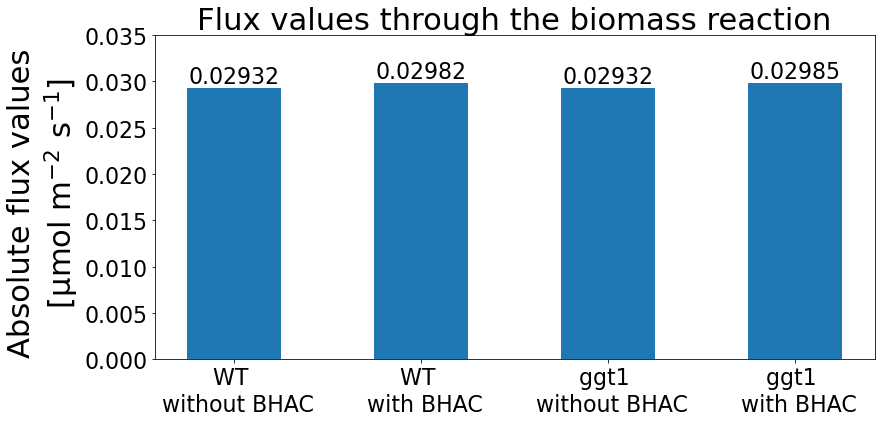

In [238]:
# plot to compare the values through the objective function (Arabidopsis biomass) between the 4 sceanrios

biomass_val = [pFBA_noBHAC.get('Arabidopsis_biomass_tx'), pFBA_BHAC.get('Arabidopsis_biomass_tx'), pFBA_noBHAC_ggt.get('Arabidopsis_biomass_tx'), pFBA_BHAC_ggt.get('Arabidopsis_biomass_tx')]

fig = plt.figure(figsize=(10,4.5))
ax = fig.add_axes([0,0,1,1])

# labels of a-axis
x_titles = ['WT \n without BHAC', 'WT \n with BHAC', 'ggt1 \n without BHAC', 'ggt1 \n with BHAC']

# y-axis
ax.set(ylabel='Absolute flux values \n [\u03BCmol m$^{-2}$ s$^{-1}$]')
ax.set_ylim(0,0.035)

# title plot
ax.set_title('Flux values through the biomass reaction')

# plot data
#plt.bar(x_titles,biomass_val, width=0.5)

# plot data and add values to each bar
bars = ax.bar(x_titles, biomass_val, width=0.5)
ax.bar_label(bars)

#plt.show()
plt.savefig('figures/biomass_comparison.png', dpi=300, bbox_inches='tight')

### Alternatives for AGAT reaction

In [44]:
print(flux_variability_analysis(c3_model, bhac_c3))

            minimum     maximum
AGAT_x -1000.000000  1000.00000
BHAA_x     2.897703     3.22272
BHAD_x     2.897703     3.22272
ISR_x      2.897703     3.22272


In [45]:
for i in c3_model.metabolites.get_by_id('L_ASPARTATE_x').reactions:
    print(i)

ASPAMINOTRANS_RXN_x: 2_KETOGLUTARATE_x + L_ASPARTATE_x <=> GLT_x + OXALACETIC_ACID_x
AGAT_x: GLYOX_x + L_ASPARTATE_x <=> GLY_x + OXALACETIC_ACID_x
L_ASPARTATE_xc: L_ASPARTATE_x <=> L_ASPARTATE_c
ISR_x: IMINOASPARTATE_x + NADH_x + PROTON_x <=> L_ASPARTATE_x + NAD_x


In [46]:
AGAT_reacts = ['ASPAMINOTRANS_RXN_x' , 'ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x', 'SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x', 'GLYCINE_AMINOTRANSFERASE_RXN_x']

In [47]:
a = c3_model.optimize().fluxes.to_frame()
for i,j in zip(AGAT_reacts,bhac_c3):
    print(a[a.index == i])
    print(a[a.index == j])
print(c3_model.optimize().objective_value)

                     fluxes
ASPAMINOTRANS_RXN_x     0.0
          fluxes
AGAT_x  2.666493
                                           fluxes
ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x     0.0
         fluxes
BHAA_x  3.22272
                                          fluxes
SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x     0.0
         fluxes
BHAD_x  3.22272
                                fluxes
GLYCINE_AMINOTRANSFERASE_RXN_x     0.0
        fluxes
ISR_x  3.22272
0.02984838953494825


In [48]:
flux_variability_analysis(c3_model, AGAT_reacts)

,minimum,maximum
ASPAMINOTRANS_RXN_x,-1000.0,1.000000e+03
ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x,0.0,1.000000e+03
SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x,0.0,8.640401e-12
GLYCINE_AMINOTRANSFERASE_RXN_x,-1000.0,1.000000e+03


In [49]:
# knocking out all other reactions, where metabolites from AGAT are part off
with c3_model:
    for i in AGAT_reacts:
        c3_model.reactions.get_by_id(i).knock_out()
    a = c3_model.optimize().fluxes.to_frame()
    for i in bhac_c3:
        print(a[a.index == i])
    print('flux through objective:', c3_model.optimize().objective_value)

          fluxes
AGAT_x  2.666493
         fluxes
BHAA_x  3.22272
         fluxes
BHAD_x  3.22272
        fluxes
ISR_x  3.22272
flux through objective: 0.02984838953494825


In [50]:
c3_model.reactions.get_by_id('ASPAMINOTRANS_RXN_x')

Reaction identifier,ASPAMINOTRANS_RXN_x
Name,ASPAMINOTRANS-RXN:Aspartate aminotransferase
Memory address,0x01f755378288
Stoichiometry,2_KETOGLUTARATE_x + L_ASPARTATE_x <=> GLT_x + OXALACETIC_ACID_x 2-KETOGLUTARATE + L-ASPARTATE <=> GLT + OXALACETIC_ACID[x]
GPR,
Lower bound,-1000.0
Upper bound,1000.0


##Analyses to compare Results from Roell et al. with our model

### Enzyme activity assay
Roell et al.: AGAT has the highest activity compared to BHAA and BHAD

In [51]:
# FVA - WT with BHAC:
with c3_model:
    set_fixed_flux_ratio({'GLYCINE_AMINOTRANSFERASE_RXN_x':1, 'AGAT_x':10},c3_model) #ggt1 reaction is forced
    set_fixed_flux_ratio({'SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x':1, 'BHAA_x':10},c3_model)

    print(flux_variability_analysis(c3_model, bhac_c3))

           minimum   maximum
AGAT_x -906.374109  2.716800
BHAA_x    2.631608  2.631608
BHAD_x    2.631608  2.631608
ISR_x     2.631608  2.631608


In [52]:
# FVA - ggt with BHAC:
with c3_model:
    c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()

    print(flux_variability_analysis(c3_model, bhac_c3))

           minimum  maximum
AGAT_x -997.333507  2.99151
BHAA_x    2.897703  3.22272
BHAD_x    2.897703  3.22272
ISR_x     2.897703  3.22272


Results show, that AGAT is capable to have a higher flux compared to the other BHAC reactions when looking at the wild type.
For the ggt1-1 mutant we can observe the opposite contradicting Roell et al.

In [53]:
# pFVA - WT with BHAC
with c3_model:
    set_fixed_flux_ratio({'GLYCINE_AMINOTRANSFERASE_RXN_x':1, 'AGAT_x':10},c3_model) #ggt1 reaction is forced
    set_fixed_flux_ratio({'SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x':1, 'BHAA_x':10},c3_model)

    print(flux_variability_analysis(c3_model, bhac_c3, pfba_factor=1))

         minimum   maximum
AGAT_x  2.716800  2.716800
BHAA_x  2.631608  2.631608
BHAD_x  2.631608  2.631608
ISR_x   2.631608  2.631608


In [54]:
# pFVA - ggt with BHAC
with c3_model:
    c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()

    print(flux_variability_analysis(c3_model, bhac_c3, pfba_factor=1))

         minimum   maximum
AGAT_x  2.944606  2.944606
BHAA_x  2.944606  2.944606
BHAD_x  2.944606  2.944606
ISR_x   2.944606  2.944606


In the wild type the results from Roell et al. are confirmed, because the flux through the AGAT reactions is higher.
For the mutant this is not the case, all reactions have the same flux which contradicts Roell et al.

In [55]:
# checking for AGAT, BHAA, BHAD and ISR what fluxes these reactions can achieve when they are objective
with c3_model:
    c3_model.objective = 'AGAT_x'
    print('AGAT:', c3_model.optimize().objective_value)

with c3_model:
    c3_model.objective = 'BHAA_x'
    print('BHAA:', c3_model.optimize().objective_value)

with c3_model:
    c3_model.objective = 'BHAD_x'
    print('BHAD:', c3_model.optimize().objective_value)

with c3_model:
    c3_model.objective = 'ISR_x'
    print('ISR:', c3_model.optimize().objective_value)

AGAT: 1000.0
BHAA: 49.96860439560434
BHAD: 49.96860439560434
ISR: 49.96860439560434


AGAT can have highest flux theoretically (all 3 reactions have the same upper/lower bounds)

In [56]:
# pFBA - WT with BHAC
with c3_model:
    set_fixed_flux_ratio({'SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x':1, 'BHAA_x':10},c3_model)
    # set_fixed_flux_ratio({'GLYCINE_AMINOTRANSFERASE_RXN_x':1, 'AGAT_x':10},c3_model)
    # the ratio for AGAT can't be active, because this reaction gets knocked out (=0), so AGAT would also be zero
    for i in AGAT_reacts:
        c3_model.reactions.get_by_id(i).knock_out()
    pFBA = round(pfba(c3_model).fluxes, 5)
    for i in bhac_c3:
        print(i, pFBA.get(i))


AGAT_x 5.68314
BHAA_x 0.0
BHAD_x 0.0
ISR_x 0.0


If we knock out the other reactions that can potentially replace AGAT, the AGAT reaction is the only one which is active out of all BHAC reactions.
If we would not apply the Serine-Glyoxylate-Aminotransferase : BHAA ratio, we get values that match the ggt1-1 mutant results

#### Fig 2B - BHAC enzyme activity

In [57]:
# get values for all BHAc reactions for the 4 scenarios
AGAT_val = [abs(pFBA_noBHAC.get('AGAT_x')), abs(pFBA_BHAC.get('AGAT_x')), abs(pFBA_noBHAC_ggt.get('AGAT_x')), abs(pFBA_BHAC_ggt.get('AGAT_x'))]
BHAA_val = [abs(pFBA_noBHAC.get('BHAA_x')), abs(pFBA_BHAC.get('BHAA_x')), abs(pFBA_noBHAC_ggt.get('BHAA_x')), abs(pFBA_BHAC_ggt.get('BHAA_x'))]
BHAD_val = [abs(pFBA_noBHAC.get('BHAD_x')), abs(pFBA_BHAC.get('BHAD_x')), abs(pFBA_noBHAC_ggt.get('BHAD_x')), abs(pFBA_BHAC_ggt.get('BHAD_x'))]
ISR_val = [abs(pFBA_noBHAC.get('ISR_x')), abs(pFBA_BHAC.get('ISR_x')), abs(pFBA_noBHAC_ggt.get('ISR_x')), abs(pFBA_BHAC_ggt.get('ISR_x'))]

In [58]:
print(AGAT_val, BHAD_val, BHAA_val, ISR_val)

[0.0, 2.7168, 0.0, 2.94461] [0.0, 2.63161, 0.0, 2.94461] [0.0, 2.63161, 0.0, 2.94461] [0.0, 2.63161, 0.0, 2.94461]


In [59]:
# general plot aesthetics
SMALL_SIZE = 13*1.7
MEDIUM_SIZE = 18*1.7
BIGGER_SIZE = 22*1.7

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

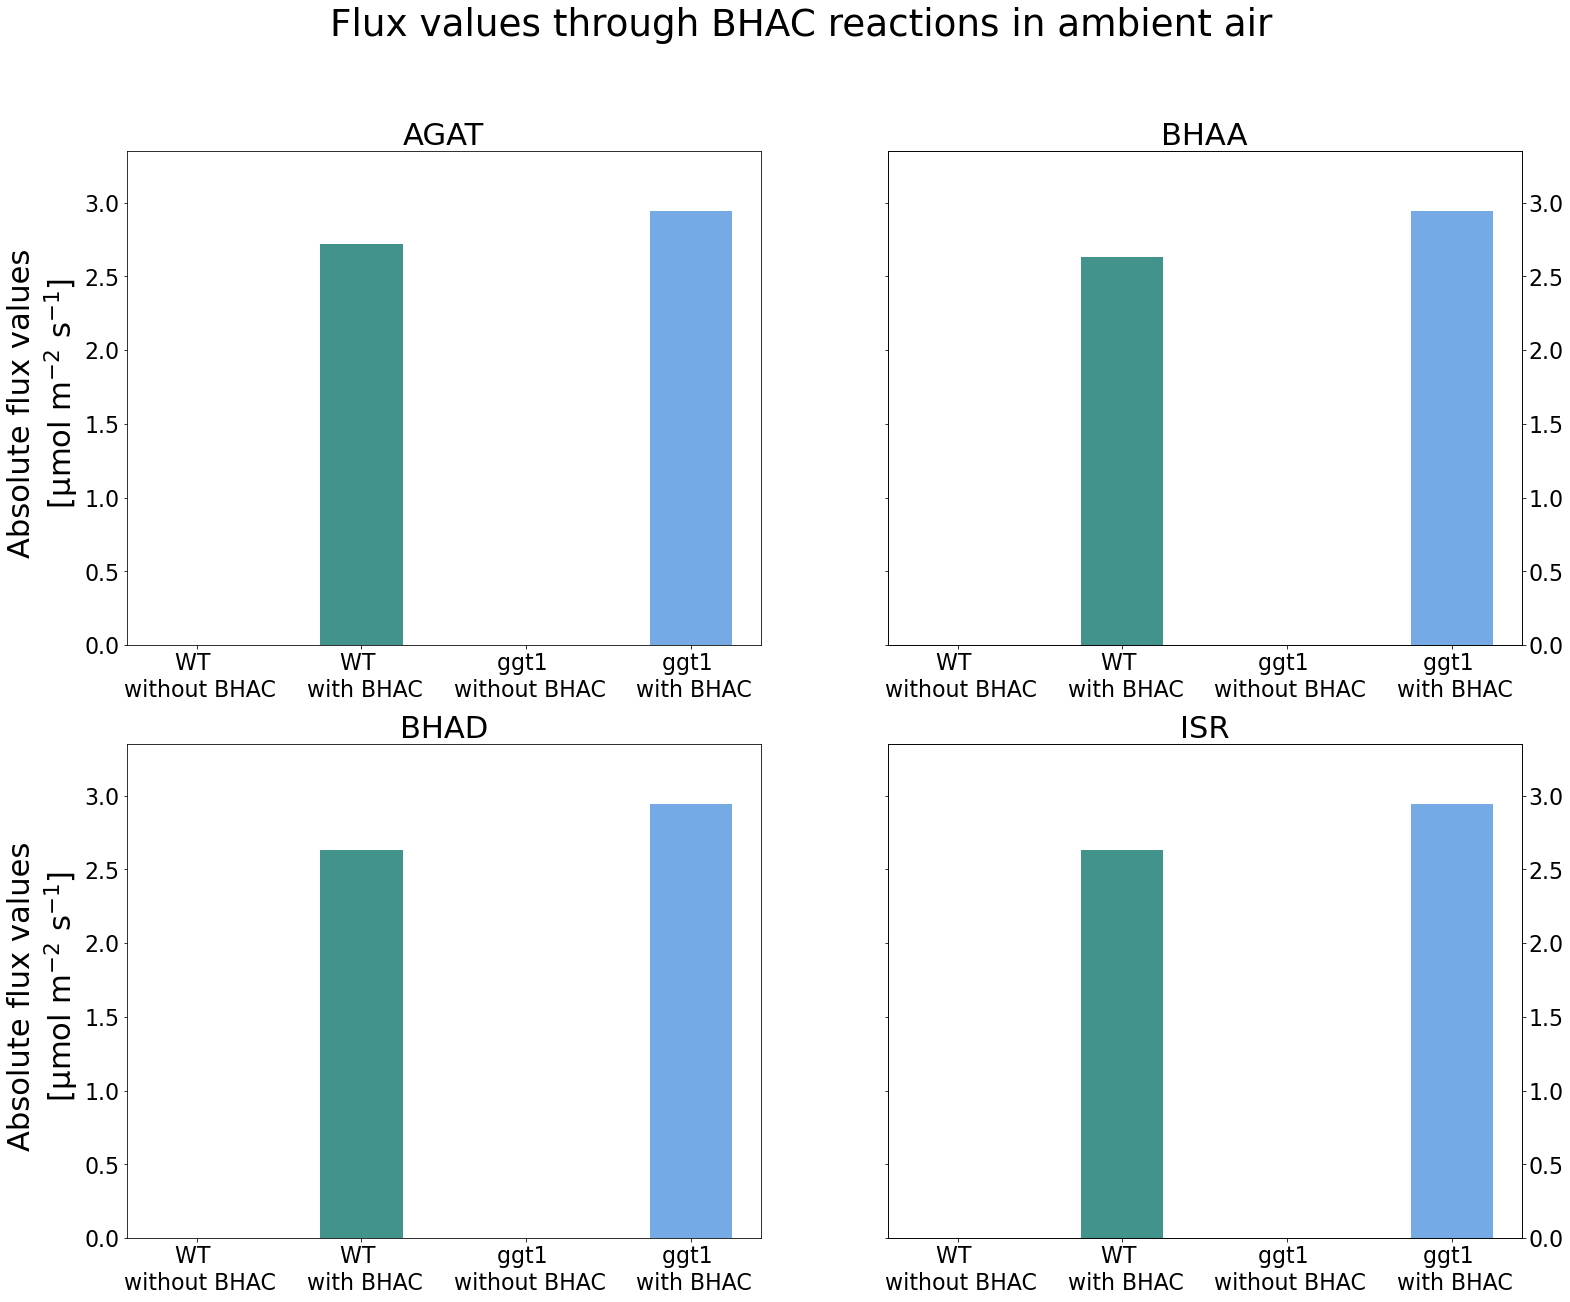

In [60]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25,20), sharey='all')
#plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=None, hspace=None)

# plot title
fig.suptitle('Flux values through BHAC reactions in ambient air')

# labeling of the x-axis
x_titles = ['WT \n without BHAC', 'WT \n with BHAC', 'ggt1 \n without BHAC', 'ggt1 \n with BHAC']

# labeling of the y-axis
ax1.set(ylabel='Absolute flux values \n [\u03BCmol m$^{-2}$ s$^{-1}$]')
ax3.set(ylabel='Absolute flux values \n [\u03BCmol m$^{-2}$ s$^{-1}$]')

# second y-axis on the right sight of the plot
ax5 = ax4.twinx()
ax5.set_ylim(0,3.35)
ax6 = ax2.twinx()
ax6.set_ylim(0,3.35)

# first plot for AGAT
ax1.bar(x_titles, AGAT_val, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax1.set_title('AGAT')
ax1.set_ylim(0,3.35)

# second plot for BHAA
ax2.bar(x_titles, BHAA_val, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax2.set_title('BHAA')
ax2.set_ylim(0,3.35)

# third plot for BHAD
ax3.bar(x_titles, BHAD_val, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax3.set_title('BHAD')
ax3.set_ylim(0,3.35)

# fourth plot for ISR
ax4.bar(x_titles, ISR_val, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax4.set_title('ISR')
ax4.set_ylim(0,3.35)

#plt.show()
plt.savefig('figures/fig2b.png', dpi=300)

### Detection of unique metabolites of BHAC
Roell et al.: beta-Hydroxyaspartate (BHA) unique for BHAC and is not naturally found in Arabidopsis

In [61]:
print(c3_model.metabolites.query('HYDROXYASPARTATE'))
print(c3_model.metabolites.query('HYDROXY_A'))
print(c3_model.metabolites.query('ASPARTATE'))
# there are no other metabolites in the model that could be BHA besides the BETA_HYDROXYASPARTATE_x I added for the BHAC

[<Metabolite BETA_HYDROXYASPARTATE_x at 0x1f7551b50c8>]
[<Metabolite DIHYDROXY_ACETONE_PHOSPHATE_c at 0x1f75517a648>, <Metabolite DIHYDROXY_ACETONE_PHOSPHATE_p at 0x1f75517acc8>, <Metabolite 5_HYDROXY_ACETOVANILLONE_c at 0x1f7551b2188>, <Metabolite a5_HYDROXY_ACETOVANILLONE_c at 0x1f7551b2248>]
[<Metabolite L_ASPARTATE_x at 0x1f75512b088>, <Metabolite CARBAMYUL_L_ASPARTATE_p at 0x1f7551328c8>, <Metabolite L_ASPARTATE_c at 0x1f755152bc8>, <Metabolite L_ASPARTATE_m at 0x1f755153088>, <Metabolite L_ASPARTATE_p at 0x1f755153408>, <Metabolite L_ASPARTATE_v at 0x1f7551535c8>, <Metabolite L_ASPARTATE_SEMIALDEHYDE_p at 0x1f75519e348>, <Metabolite BETA_HYDROXYASPARTATE_x at 0x1f7551b50c8>, <Metabolite IMINOASPARTATE_x at 0x1f7551b5248>]


In [62]:
print('BHAA_x in wt without BHAC:', pFBA_noBHAC.get('BHAA_x'))
print('BHAA_x in ggt without BHAC:', pFBA_noBHAC_ggt.get('BHAA_x'))

print('BHAA_x in wt with BHAC:', pFBA_BHAC.get('BHAA_x'))
print('BHAA_x in ggt with BHAC:', pFBA_BHAC_ggt.get('BHAA_x'))

BHAA_x in wt without BHAC: 0.0
BHAA_x in ggt without BHAC: 0.0
BHAA_x in wt with BHAC: 2.63161
BHAA_x in ggt with BHAC: 2.94461


Roell et al.: BHA just detectable when BHAC plant is grown under PR conditions

In [63]:
# standard: Rubisco ratio 3:1 (PR conditions), there is flux through BHAA producing BHA

# no Rubisco rate to simulate conditions without PR
# ratio needs to be blocked in the section "Reading the model > Adding Rubisco.." and then run everything (!) again to simulate HC

# pFBA - WT with BHAC
with c3_model:
    pFBA = pfba(c3_model).fluxes
    print('BHAA_x', pFBA.get('BHAA_x'))

BHAA_x 2.9446064312161253


for AC (Rubisco ratio 3:1):
for HC (no Rubisco ratio): -0.159

In [64]:
# ggt with BHAC
with c3_model:
    c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()
    pFBA = pfba(c3_model).fluxes
    print('BHAA_x', pFBA.get('BHAA_x'))
    print('BHAA_x', pFBA.get('GLY3KIN_RXN_p'))
    print('BHAA_x', pFBA.get('SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'))
    print('BHAA_x', pFBA.get('AGAT_x'))
    print('BHAA_x', pFBA.get('BHAD_x'))
    print('BHAA_x', pFBA.get('ISR_x'))
    print('BHAA_x', pFBA.get('RXN_969_x'))
    print('BHAA_x', pFBA.get('GCVMULTI_RXN_m'))

BHAA_x 2.9446064312161266
BHAA_x 0.0
BHAA_x 0.0
BHAA_x 2.9446064312161266
BHAA_x 2.9446064312161266
BHAA_x 2.9446064312161266
BHAA_x 5.889212862432253
BHAA_x 0.27811343867611865


for AC (Rubisco ratio 3:1):
for HC (no Rubisco ratio): -0.159

There is no flux through the BHAA reaction producing BHA under high CO2 concentration (i.e. no PR) in wt with BHAC. Contrasting, the ggt1-1 mutant still has a flux, but a negative one (BHAD and ISR also negative flux while AGAT has a positive), i.e. reactions run backwards and not as intended

Results by Roell et al. got confirmed

#### Fig 3A/B - beta-hydroxyaspartate levels

In [65]:
# level of beta-hydroxyaspartate depending on BHAC/CO2/Background
BHA_reactions = search_reactions('BETA_HYDROXYASPARTATE', 'x')

There are 2 reactions including the following metabolites:
 ['BETA_HYDROXYASPARTATE_x'] 



In [66]:
# values depend if a rubisco ratio is chosen in section 'Reading the models', then we get results for AC (3:1 ratio) or HC (no ratio) conditions
BHA = [flux_values_sum(BHA_reactions, 'n', 'wt', plot='plot'), flux_values_sum(BHA_reactions, 'y', 'wt', plot='plot'), flux_values_sum(BHA_reactions, 'n', 'ggt', plot='plot'), flux_values_sum(BHA_reactions, 'y', 'ggt', plot='plot')]
BHA

[0.0, 5.2632, 0.0, 5.8892]

In [67]:
BHA_ac = [0, 5.2632,  0, 5.8892]
BHA_hc = [0,0,0, 0.3183]

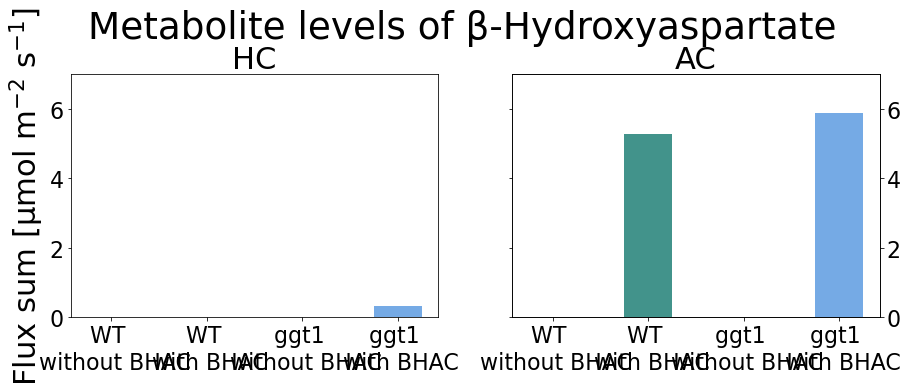

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14.5,5), sharey='all')
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=None, hspace=None)
fig.suptitle('Metabolite levels of \u03B2-Hydroxyaspartate')

x_titles = ['WT \n without BHAC', 'WT \n with BHAC', 'ggt1 \n without BHAC', 'ggt1 \n with BHAC']

ax1.set(ylabel='Flux sum [\u03BCmol m$^{-2}$ s$^{-1}$]')

ax3 = ax2.twinx()
ax3.set_ylim(0,7)

ax1.bar(x_titles, BHA_hc, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax1.set_title('HC')
ax1.set_ylim(0,7)

ax2.bar(x_titles, BHA_ac, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax2.set_title('AC')
ax2.set_ylim(0,7)

plt.show()
#plt.savefig('figures/fig3a.png', dpi=300)

### Variations in amount of certain metabolites associated with BHAC

#### Glycine
Roell et al.:
- Glycine levels decreased twofold in WT with BHAC, because Glycine gets converted into BHA
- in ggt1 mutant Glycine levels are 10-fold lower than in WT (with and without BHAC)

In [69]:
# get all reactions with Glycine (across al compartments)
gly_reactions = search_reactions('GLY', 'all')

# pFBA/flux sum - WT without BHAC
flux_values_sum(gly_reactions, 'n', 'wt')

There are 24 reactions including the following metabolites:
 ['GLY_c', 'GLY_v', 'GLY_x', 'GLY_m', 'GLY_p'] 

GLYRIBONUCSYN_RXN_p = 0.00155
GLYCINE_AMINOTRANSFERASE_RXN_x = 2.93843
GLYCINE_TRNA_LIGASE_RXN_c = 0.0
SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 2.84629
BHAA_x = 0.0
AGAT_x = 0.0
GLYOHMETRANS_RXN_p = 0.00155
ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
THREONINE_ALDOLASE_RXN_c = 0.76426
GCVMULTI_RXN_m = 3.16554
GLYOHMETRANS_RXN_c = 0.0
GLYOHMETRANS_RXN_m = -3.09199
sGLY_biomass = 0.29145

 ---------------- 
 The flux sum is: 13.1011


In [70]:
# pFBA/flux sum - WT with BHAC
flux_values_sum(gly_reactions, 'y', 'wt')

GLYRIBONUCSYN_RXN_p = 0.00158
GLYCINE_AMINOTRANSFERASE_RXN_x = 0.27168
GLYCINE_TRNA_LIGASE_RXN_c = 0.0
SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.26316
BHAA_x = 2.63161
AGAT_x = 2.7168
GLYOHMETRANS_RXN_p = 0.00158
ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
THREONINE_ALDOLASE_RXN_c = 0.77728
GCVMULTI_RXN_m = 0.58785
GLYOHMETRANS_RXN_c = 0.0
GLYOHMETRANS_RXN_m = -0.51305
sGLY_biomass = 0.29641

 ---------------- 
 The flux sum is: 8.061


Flux sum with BHAC in wild type is lower than without BHAC (confirms Roell et al.)

In [71]:
# pFBA/flux sum - ggt1 without BHAC
print(flux_values_sum(gly_reactions, 'n', 'ggt', plot='plot'))

# pFBA/flux sum - ggt1 with BHAC
print(flux_values_sum(gly_reactions, 'y', 'ggt', plot='plot'))

13.1011
7.4454


Although flux sum with BHAC in ggt1-1 mutant is lower than without BHAC, the results comparing ggt1-1 mutant and wt are the same, which contradicts Roell et al.

#### Aspartate
Roell et al.: Aspartate increases sixfold, because Asp is BHAC intermediate and product of OAA transamination

In [72]:
# search for Aspartate reactions in the Peroxisome
asp_x_reactions = search_reactions('L_ASPARTATE', 'x')

There are 4 reactions including the following metabolites:
 ['L_ASPARTATE_x'] 



In [73]:
# pFBA/flux sum - WT without BHAC
flux_values_sum(asp_x_reactions, 'n', 'wt')

# just regarding peroxisome: without bhac there is no aspartate in here

ISR_x = 0.0
ASPAMINOTRANS_RXN_x = 0.0
AGAT_x = 0.0

 ---------------- 
 The flux sum is: 0.0


In [74]:
# pFBA/flux sum - WT with BHAC
flux_values_sum(asp_x_reactions, 'y', 'wt')

ISR_x = 2.63161
ASPAMINOTRANS_RXN_x = -0.08519
AGAT_x = 2.7168

 ---------------- 
 The flux sum is: 5.4336


Without the BHAC there is no aspartate in the peroxisome (where the BHAC would be), but with BHAC with have a flux value.

In [75]:
# get all reactions for Aspartate across all compartments
asp_reactions = search_reactions('L_ASPARTATE', 'all')

There are 26 reactions including the following metabolites:
 ['L_ASPARTATE_x', 'L_ASPARTATE_c', 'L_ASPARTATE_m', 'L_ASPARTATE_p', 'L_ASPARTATE_v'] 



In [76]:
# pFBA/flux sum - WT without BHAC
flux_values_sum(asp_reactions, 'n', 'wt')

sASP_biomass = -0.10768
ASPAMINOTRANS_RXN_m = 0.0
ASPAMINOTRANS_RXN_p = -1.2717
ISR_x = 0.0
ASPARTATEKIN_RXN_p = 1.15188
ASPARTATE_TRNA_LIGASE_RXN_c = 0.0
ASPAMINOTRANS_RXN_c = -0.18285
ADENYLOSUCCINATE_SYNTHASE_RXN_p = 0.03698
ASPARAGHYD_RXN_c = 0.0
ASPAMINOTRANS_RXN_x = 0.0
AGAT_x = 0.0
ASNSYNA_RXN_c = 0.07518
SAICARSYN_RXN_p = 0.00155
ASPCARBTRANS_RXN_p = 0.0017
ARGSUCCINSYN_RXN_p = 0.07959

 ---------------- 
 The flux sum is: 2.9091


In [77]:
# pFBA/flux sum - WT with BHAC
flux_values_sum(asp_reactions, 'y', 'wt')

sASP_biomass = -0.10951
ASPAMINOTRANS_RXN_m = 0.0
ASPAMINOTRANS_RXN_p = -1.29336
ISR_x = 2.63161
ASPARTATEKIN_RXN_p = 1.1715
ASPARTATE_TRNA_LIGASE_RXN_c = 0.0
ASPAMINOTRANS_RXN_c = -0.18597
ADENYLOSUCCINATE_SYNTHASE_RXN_p = 0.03761
ASPARAGHYD_RXN_c = 0.0
ASPAMINOTRANS_RXN_x = -0.08519
AGAT_x = 2.7168
ASNSYNA_RXN_c = 0.07646
SAICARSYN_RXN_p = 0.00158
ASPCARBTRANS_RXN_p = 0.00173
ARGSUCCINSYN_RXN_p = 0.08094

 ---------------- 
 The flux sum is: 8.3923


There is more aspartate in the WT cell with BHAC than without confirming Roell et al. results

In [78]:
# pFBA/flux sum - ggt1 without BHAC
print(flux_values_sum(asp_reactions, 'n', 'ggt', plot='plot'))

# pFBA/flux sum - ggt1 with BHAC
print(flux_values_sum(asp_reactions, 'y', 'ggt', plot='plot'))

2.9091
8.8509


There is more aspartate in the ggt1-1 mutant cell with BHAC than without confirming Roell et al. results

#### Malate
Roell et al.: Malate increases twofold, because Mal is produced by reduction of OAA

In [79]:
# get the reactions where MAL in all compartments is part of
mal_reactions = search_reactions('MAL', 'all')

There are 46 reactions including the following metabolites:
 ['MAL_p', 'MAL_m', 'MAL_x', 'MAL_v', 'MAL_c'] 



In [80]:
# pFBA/flux sum - WT without BHAC
flux_values_sum(mal_reactions, 'n', 'wt')

FUMHYDR_RXN_c = 0.11812
MALSYN_RXN_x = 0.0
sMAL_biomass = -0.05435
MALATE_DEH_RXN_p = 0.11635
MALIC_NADP_RXN_c = 0.0
MALATE_DEH_RXN_c = -1.83983
MALATE_DEHYDROGENASE_NADP_RXN_p = 0.0
MALATE_DEH_RXN_m = -1.05904
MALIC_NADP_RXN_p = 0.0
FUMHYDR_RXN_m = 0.0
MALATE_DEH_RXN_x = 2.84629
1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m = 0.0

 ---------------- 
 The flux sum is: 6.034


In [81]:
# pFBA/flux sum - WT with BHAC
flux_values_sum(mal_reactions, 'y', 'wt')

FUMHYDR_RXN_c = 0.12014
MALSYN_RXN_x = 0.0
sMAL_biomass = -0.05527
MALATE_DEH_RXN_p = 1.46853
MALIC_NADP_RXN_c = 0.0
MALATE_DEH_RXN_c = -5.13582
MALATE_DEHYDROGENASE_NADP_RXN_p = 0.0
MALATE_DEH_RXN_m = 0.0
MALIC_NADP_RXN_p = 0.83738
FUMHYDR_RXN_m = 0.0
MALATE_DEH_RXN_x = 2.89477
1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m = 0.0

 ---------------- 
 The flux sum is: 10.5119


More malate in the wt (higher flux sum with BHAC than without bhac) confirms Roell et al. results

In [82]:
# pFBA/flux sum - ggt1 without BHAC
print(flux_values_sum(mal_reactions, 'n', 'ggt', plot='plot'))

# pFBA/flux sum - ggt1 with BHAC
print(flux_values_sum(mal_reactions, 'y', 'ggt', plot='plot'))

6.034
11.0105


More malate in the ggt1-1 mutant (higher flux sum with BHAC than without bhac) confirms Roell et al. results

#### Fig 3C - Gly/Asp/Mal Metabolite Levels

In [83]:
# getting the glycine values (flux sum of all reactions where glycine is part of) for all 4 scenarios
Gly_ac = [flux_values_sum(gly_reactions, 'n', 'wt', plot='plot'), flux_values_sum(gly_reactions, 'y', 'wt', plot='plot'), flux_values_sum(gly_reactions, 'n', 'ggt', plot='plot'), flux_values_sum(gly_reactions, 'y', 'ggt', plot='plot')]
Gly_ac

[13.1011, 8.061, 13.1011, 7.4454]

In [84]:
# getting the aspartate values for all 4 scenarios
Asp_ac = [flux_values_sum(asp_reactions, 'n', 'wt', plot='plot'), flux_values_sum(asp_reactions, 'y', 'wt', plot='plot'), flux_values_sum(asp_reactions, 'n', 'ggt', plot='plot'), flux_values_sum(asp_reactions, 'y', 'ggt', plot='plot')]
Asp_ac

[2.9091, 8.3923, 2.9091, 8.8509]

In [85]:
# getting the malate values for all 4 scenarios
Mal_ac = [flux_values_sum(mal_reactions, 'n', 'wt', plot='plot'),flux_values_sum(mal_reactions, 'y', 'wt', plot='plot'), flux_values_sum(mal_reactions, 'n', 'ggt', plot='plot'), flux_values_sum(mal_reactions, 'y', 'ggt', plot='plot')]
Mal_ac

[6.034, 10.5119, 6.034, 11.0105]

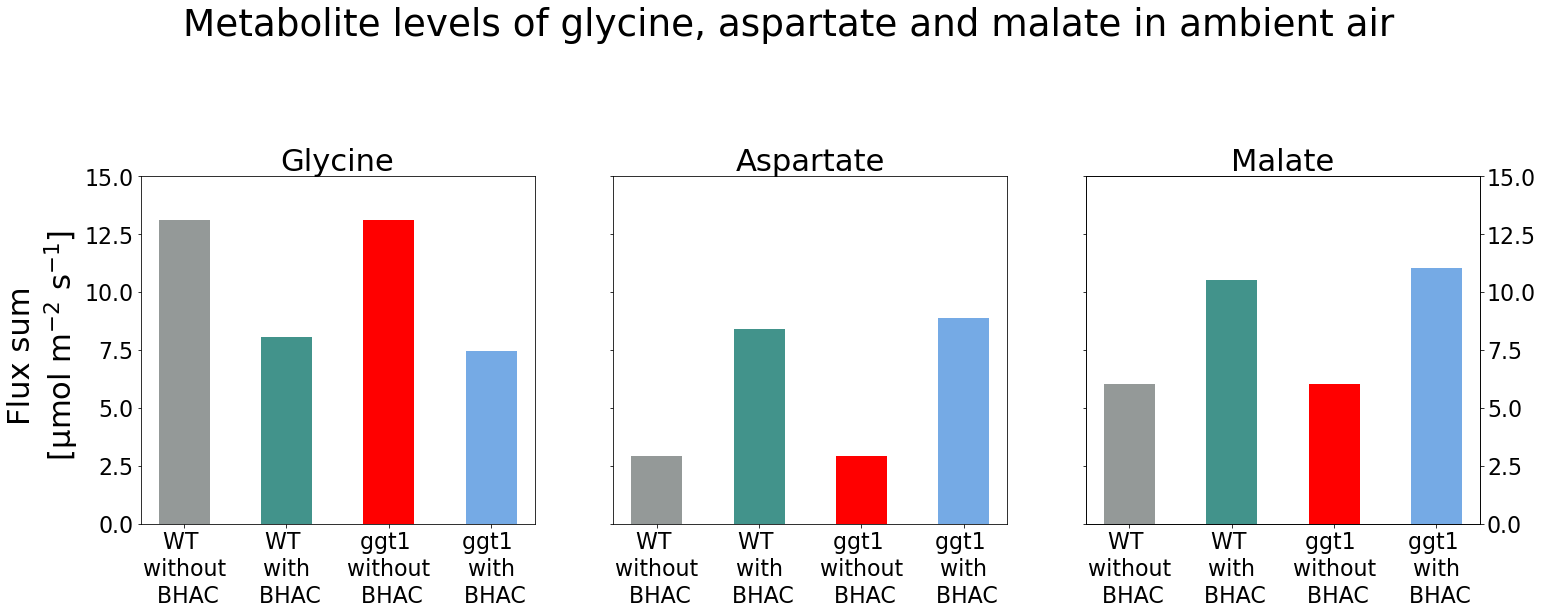

In [86]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(24,6*1.4), sharey='all')
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.7, wspace=None, hspace=None)
fig.suptitle('Metabolite levels of glycine, aspartate and malate in ambient air')

x_titles = ['WT \n without \n BHAC', 'WT \n with \n BHAC', 'ggt1 \n without \n BHAC', 'ggt1 \n with \n BHAC']

ax1.set(ylabel='Flux sum \n [\u03BCmol m$^{-2}$ s$^{-1}$]')

ax4 = ax3.twinx()
ax4.set_ylim(0,15)

ax1.bar(x_titles, Gly_ac, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax1.set_title('Glycine')
ax1.set_ylim(0,15)

ax2.bar(x_titles, Asp_ac, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax2.set_title('Aspartate')
ax2.set_ylim(0,15)

ax3.bar(x_titles, Mal_ac, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax3.set_title('Malate')
ax3.set_ylim(0,15)

plt.show()
#plt.savefig('figures/fig3c.png', dpi=300, bbox_inches = 'tight')

### Ammonia reduction
Roell et al.:
- free cellular ammonia is reduced by 20%
- BHAC prevents NH4+ release in mitochondria
- BHAC avoids chloroplastic nitrogen reassimilation by glutamine synthase

In [87]:
# get all reactions where Ammonia is part of across all compartments
nh4_reactions = search_reactions('AMMONIUM', 'all')

There are 27 reactions including the following metabolites:
 ['AMMONIUM_c', 'AMMONIUM_e', 'AMMONIUM_p', 'AMMONIUM_m', 'AMMONIUM_v'] 



In [88]:
# pFBA/flux sum - WT without BHAC
print(flux_values_sum(nh4_reactions, 'n', 'wt', plot='plot'))

# pFBA/flux sum - WT with BHAC
print(flux_values_sum(nh4_reactions, 'y', 'wt', plot='plot'))

12.098
7.0408


In [89]:
# pFBA/flux sum - ggt1 without BHAC
print(flux_values_sum(nh4_reactions, 'n', 'ggt', plot='plot'))

# pFBA/flux sum - ggt1 with BHAC
print(flux_values_sum(nh4_reactions, 'y', 'ggt', plot='plot'))

12.098
6.4273


Less ammonia in the wt and ggt1-1 mutant (lower flux sum with BHAC than without bhac) confirms Roell et al. results

In [90]:
# reaction in mitochondria where Glycine gets converted so CO2 and NH4+ etc. get released
c3_model.reactions.GCVMULTI_RXN_m

Reaction identifier,GCVMULTI_RXN_m
Name,GCVMULTI-RXN:NIL
Memory address,0x01f75543ce88
Stoichiometry,GLY_m + NAD_m + THF_m --> AMMONIUM_m + CARBON_DIOXIDE_m + METHYLENE_THF_m + NADH_m GLY + NAD + THF --> AMMONIUM + CARBON-DIOXIDE + METHYLENE-THF + NADH
GPR,
Lower bound,0.0
Upper bound,1000.0


In [91]:
# pFBA - WT without BHAC
print('GCVMULTI_RXN_m', pFBA_noBHAC.get('GCVMULTI_RXN_m'))

GCVMULTI_RXN_m 3.16554


In [92]:
# pFBA - WT with BHAC
print('GCVMULTI_RXN_m', pFBA_BHAC.get('GCVMULTI_RXN_m'))

GCVMULTI_RXN_m 0.58785


In [93]:
# pFBA - ggt without BHAC
print('GCVMULTI_RXN_m', pFBA_noBHAC_ggt.get('GCVMULTI_RXN_m'))

# pFBA - ggt with BHAC
print('GCVMULTI_RXN_m', pFBA_BHAC_ggt.get('GCVMULTI_RXN_m'))

GCVMULTI_RXN_m 3.16554
GCVMULTI_RXN_m 0.27811


Flux through reaction releasing, among other things, ammonia is much smaller with BHAC than without (for wt and ggt1-1 mutant) confirming Roell et al. results

In [94]:
# get reaction for glutamine synthase
c3_model.reactions.GLUTAMINESYN_RXN_p

Reaction identifier,GLUTAMINESYN_RXN_p
Name,GLUTAMINESYN-RXN:Glutamate--ammonia ligase
Memory address,0x01f7554af488
Stoichiometry,AMMONIUM_p + ATP_p + GLT_p --> ADP_p + GLN_p + 0.9 PROTON_p + Pi_p AMMONIUM + ATP + GLT --> ADP + GLN + 0.9 PROTON + Pi[p]
GPR,
Lower bound,0.0
Upper bound,1000.0


In [95]:
# pFBA - WT without BHAC
print('GLUTAMINESYN_RXN_p', pFBA_noBHAC.get('GLUTAMINESYN_RXN_p'))

GLUTAMINESYN_RXN_p 5.89252


In [96]:
# pFBA - WT with BHAC
print('GLUTAMINESYN_RXN_p', pFBA_BHAC.get('GLUTAMINESYN_RXN_p'))

GLUTAMINESYN_RXN_p 3.36128


In [97]:
# pFBA - ggt without BHAC
print('GLUTAMINESYN_RXN_p', pFBA_noBHAC_ggt.get('GLUTAMINESYN_RXN_p'))

# pFBA - ggt with BHAC
print('GLUTAMINESYN_RXN_p', pFBA_BHAC_ggt.get('GLUTAMINESYN_RXN_p'))

GLUTAMINESYN_RXN_p 5.89252
GLUTAMINESYN_RXN_p 3.05436


Flux values through glutamine synthase are smaller with BHAC than without for wt and ggt1-1 mutant confirming Roell et al. results

#### Fig 4C - Levels of NH4+

In [98]:
# depending if a rubisco ratio is chosen in section 'Reading the models', then we get results for AC (3:1 ratio) or HC (no ratio) conditions
nh4 = [flux_values_sum(nh4_reactions, 'n', 'wt', plot='plot'), flux_values_sum(nh4_reactions, 'y', 'wt', plot='plot'), flux_values_sum(nh4_reactions, 'n', 'ggt', plot='plot'), flux_values_sum(nh4_reactions, 'y', 'ggt', plot='plot')]
nh4

[12.098, 7.0408, 12.098, 6.4273]

In [99]:
flux_values_sum(nh4_reactions, 'n', 'ggt')
flux_values_sum(nh4_reactions, 'y', 'ggt')

PHE_NH4_Lyase_c = 0.0
CARBAMATE_KINASE_RXN_p = 0.08129
AMP_DEAMINASE_RXN_c = 0.00083
GLUTAMINESYN_RXN_m = 0.0
GLUTAMATE_DEHYDROGENASE_RXN_m = 0.0
LCYSDESULF_RXN_c = 0.0
THREDEHYD_RXN_p = 0.09573
ASPARAGHYD_RXN_c = 0.0
FERREDOXIN_NITRITE_REDUCTASE_RXN_p = 2.75107
RXN_13202_p = 0.0
ASNSYNA_RXN_c = 0.07518
DSERDEAM_RXN_c = 0.0
RXN_15130_p = 0.0
GLUTAMINESYN_RXN_p = 5.89252
GCVMULTI_RXN_m = 3.16554
GLUTAMINESYN_RXN_c = 0.0
CYSTATHIONINE_BETA_LYASE_RXN_p = 0.03582
UREASE_RXN_c = 0.0

 ---------------- 
 The flux sum is: 12.098
PHE_NH4_Lyase_c = 0.0
CARBAMATE_KINASE_RXN_p = 0.08275
AMP_DEAMINASE_RXN_c = 0.00084
GLUTAMINESYN_RXN_m = 0.0
GLUTAMATE_DEHYDROGENASE_RXN_m = 0.0
LCYSDESULF_RXN_c = 0.0
THREDEHYD_RXN_p = 0.09746
ASPARAGHYD_RXN_c = 0.0
FERREDOXIN_NITRITE_REDUCTASE_RXN_p = 2.80077
RXN_13202_p = 0.0
ASNSYNA_RXN_c = 0.07654
DSERDEAM_RXN_c = 0.0
RXN_15130_p = 0.0
GLUTAMINESYN_RXN_p = 3.05436
GCVMULTI_RXN_m = 0.27811
GLUTAMINESYN_RXN_c = 0.0
CYSTATHIONINE_BETA_LYASE_RXN_p = 0.03647
UREASE_R

In [100]:
# under HC reactions that differ between ggt with and without
for i in ['FERREDOXIN_NITRITE_REDUCTASE_RXN_p',
"CYSTATHIONINE_BETA_LYASE_RXN_p",
"ASNSYNA_RXN_c",
"CARBAMATE_KINASE_RXN_p",
"THREDEHYD_RXN_p",
"GLUTAMINESYN_RXN_p",]:
    print(c3_model.reactions.get_by_id(i))

FERREDOXIN_NITRITE_REDUCTASE_RXN_p: NITRITE_p + 8.0 PROTON_p + 6.0 Reduced_ferredoxins_p --> AMMONIUM_p + 6.0 Oxidized_ferredoxins_p + 2.0 WATER_p
CYSTATHIONINE_BETA_LYASE_RXN_p: L_CYSTATHIONINE_p + WATER_p --> AMMONIUM_p + HOMO_CYS_p + PYRUVATE_p
ASNSYNA_RXN_c: AMMONIUM_c + ATP_c + L_ASPARTATE_c --> AMP_c + ASN_c + PPI_c + PROTON_c
CARBAMATE_KINASE_RXN_p: AMMONIUM_p + ATP_p + CARBON_DIOXIDE_p <=> ADP_p + CARBAMOYL_P_p + 1.9 PROTON_p
THREDEHYD_RXN_p: THR_p --> 2_OXOBUTANOATE_p + AMMONIUM_p
GLUTAMINESYN_RXN_p: AMMONIUM_p + ATP_p + GLT_p --> ADP_p + GLN_p + 0.9 PROTON_p + Pi_p


In [101]:
# save values from both CO2 conditions for plotting
nh4_ac = [12.098, 7.0408 , 12.098, 6.4273]
nh4_hc = [8.4146, 8.4146, 8.4146, 8.4249]

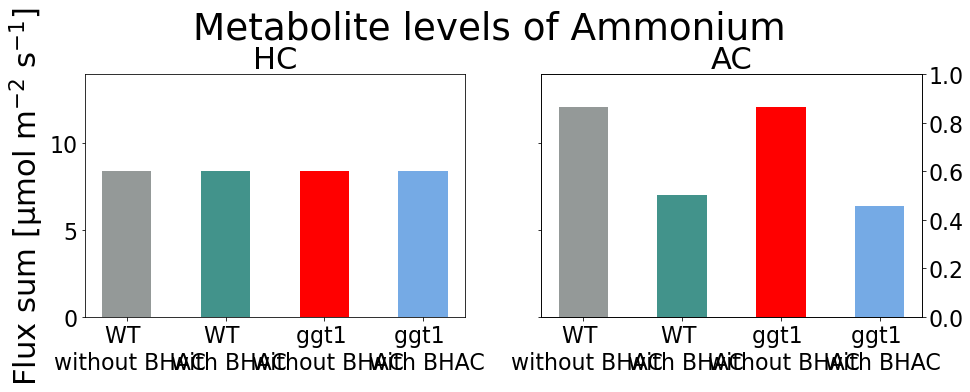

In [240]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey='all')
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=None, hspace=None)
fig.suptitle('Metabolite levels of Ammonium')

x_titles = ['WT \n without BHAC', 'WT \n with BHAC', 'ggt1 \n without BHAC', 'ggt1 \n with BHAC']

ax1.set(ylabel='Flux sum [\u03BCmol m$^{-2}$ s$^{-1}$]')

ax3 = ax2.twinx()
ax2.set_ylim(0,14)

ax1.bar(x_titles, nh4_hc, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax1.set_title('HC')
ax1.set_ylim(0,14)

ax2.bar(x_titles, nh4_ac, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax2.set_title('AC')
ax2.set_ylim(0,14)

plt.show()
#plt.savefig('figures/fig4c.png', dpi=300)

### Accumulation Amino Acids
Roell et al.:
- certain Amino acids get produced, when BHAC is in plant: Glutamate & Ornithine (urea cycle); Lysine & Methionine & Threonine (OAA-derived carbon skeletons with Aspartate in Chloroplast)
- rerouting of photorespiratory glycolate into amino acids

#### Glutamate

There are 2 reactions that can produce glutamate in the L-citrulline metabolism (=superpathway, where ura cycle is a part of); the Glutamate Synthase Ferredoxin is again mentioned by Roell et al. as part of the GS2/Fd-GOGAT complex (complex is supposed to have less activity with BHAC), so this reaction should not be responsible for a higher glutamate production. The other reaction, ornithine-δ-aminotransferase, produces glutamate from ornithine.
According to the Budget Plot of glutamate the reaction that produces most ist Glutamate Synthase Ferredoxin.

In [278]:
# the following reactions are part of the superpathway and produce glutamate
print(c3_model.reactions.get_by_id('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p').reaction)
print(c3_model.reactions.get_by_id('ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m').reaction)

2_KETOGLUTARATE_p + GLN_p + 2.0 PROTON_p + 2.0 Reduced_ferredoxins_p --> 2.0 GLT_p + 2.0 Oxidized_ferredoxins_p
2_KETOGLUTARATE_m + L_ORNITHINE_m <=> GLT_m + L_GLUTAMATE_GAMMA_SEMIALDEHYDE_m


In [279]:
# pFBA - WT without BHAC
print('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p', pFBA_noBHAC.get('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p'))
print('ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m', pFBA_noBHAC.get('ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m'))

GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p 5.77959
ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m 0.0


In [280]:
# pFBA - WT with BHAC
print('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p', pFBA_BHAC.get('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p'))
print('ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m', pFBA_BHAC.get('ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m'))

GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p 3.24643
ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m -0.0


In [281]:
# pFBA - ggt for glt producing reaction
# without BHAC
print('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p', pFBA_noBHAC_ggt.get('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p'))
print('ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m', pFBA_noBHAC_ggt.get('ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m'))
# with BHAC
print('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p', pFBA_BHAC_ggt.get('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p'))
print('ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m', pFBA_BHAC_ggt.get('ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m'))

GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p 5.77959
ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m 0.0
GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p 2.93939
ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m 0.0


In [107]:
# get reactions where Glt (from every compartment) is part of
glt_reactions = search_reactions('GLT', 'all')

There are 61 reactions including the following metabolites:
 ['GLT_m', 'GLT_p', 'GLT_c', 'GLT_v', 'GLT_x'] 



In [108]:
# pFBA/flux sum - WT without BHAC
flux_values_sum(glt_reactions, 'n', 'wt')

BRANCHED_CHAINAMINOTRANSFERILEU_RXN_p = -0.09573
TYROSINE_AMINOTRANSFERASE_RXN_c = 0.0
ASPAMINOTRANS_RXN_m = 0.0
FGAMSYN_RXN_p = 0.00155
HISTAMINOTRANS_RXN_p = 0.03543
ASPAMINOTRANS_RXN_p = -1.2717
PSERTRANSAM_RXN_p = 0.0
CTPSYN_RXN_p = 0.00096
ACETYLORNTRANSAM_RXN_p = 0.07959
2_AMINOADIPATE_AMINOTRANSFERASE_RXN_c = 0.0
ANTHRANSYN_RXN_p = 0.01798
GLURS_RXN_c = 0.0
GLUTDECARBOX_RXN_c = 0.0
GLYCINE_AMINOTRANSFERASE_RXN_x = 2.93843
GMP_SYN_GLUT_RXN_c = 0.00083
GLUTAMINESYN_RXN_m = 0.0
ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m = 0.0
GLUTAMATE_DEHYDROGENASE_RXN_m = 0.0
ASPAMINOTRANS_RXN_c = -0.18285
CYSTEINE_AMINOTRANSFERASE_RXN_m = 0.0
ALANINE_AMINOTRANSFERASE_RXN_x = 0.0
BRANCHED_CHAINAMINOTRANSFERLEU_RXN_p = -0.1692
BRANCHED_CHAINAMINOTRANSFERVAL_RXN_p = -0.15588
ALANINE_AMINOTRANSFERASE_RXN_c = -0.24583
ASPAMINOTRANS_RXN_x = 0.0
GABATRANSAM_RXN_m = 0.0
PYRROLINECARBDEHYDROG_RXN_NADP_m = 0.0
ALANINE_AMINOTRANSFERASE_RXN_m = 0.0
BRANCHED_CHAINAMINOTRANSFERLEU_RXN_m = 0.0
GLUTAMATE_N_ACETYLTRAN

In [109]:
# pFBA/flux sum - WT with BHAC
flux_values_sum(glt_reactions, 'y', 'wt')

BRANCHED_CHAINAMINOTRANSFERILEU_RXN_p = -0.09736
TYROSINE_AMINOTRANSFERASE_RXN_c = 0.0
ASPAMINOTRANS_RXN_m = 0.0
FGAMSYN_RXN_p = 0.00158
HISTAMINOTRANS_RXN_p = 0.03603
ASPAMINOTRANS_RXN_p = -1.29336
PSERTRANSAM_RXN_p = 0.0
CTPSYN_RXN_p = 0.00098
ACETYLORNTRANSAM_RXN_p = 0.08094
2_AMINOADIPATE_AMINOTRANSFERASE_RXN_c = 0.0
ANTHRANSYN_RXN_p = 0.01829
GLURS_RXN_c = 0.0
GLUTDECARBOX_RXN_c = 0.0
GLYCINE_AMINOTRANSFERASE_RXN_x = 0.27168
GMP_SYN_GLUT_RXN_c = 0.00084
GLUTAMINESYN_RXN_m = 0.0
ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m = -0.0
GLUTAMATE_DEHYDROGENASE_RXN_m = 0.0
ASPAMINOTRANS_RXN_c = -0.18597
CYSTEINE_AMINOTRANSFERASE_RXN_m = 0.0
ALANINE_AMINOTRANSFERASE_RXN_x = 0.0
BRANCHED_CHAINAMINOTRANSFERLEU_RXN_p = -0.17208
BRANCHED_CHAINAMINOTRANSFERVAL_RXN_p = -0.15853
ALANINE_AMINOTRANSFERASE_RXN_c = -0.25001
ASPAMINOTRANS_RXN_x = -0.08519
GABATRANSAM_RXN_m = 0.0
PYRROLINECARBDEHYDROG_RXN_NADP_m = 0.0
ALANINE_AMINOTRANSFERASE_RXN_m = 0.0
BRANCHED_CHAINAMINOTRANSFERLEU_RXN_m = 0.0
GLUTAMATE_N_AC

In [110]:
# pFBA - ggt without BHAC
print(flux_values_sum(glt_reactions, 'n', 'ggt', plot='plot'))

# pFBA/flux sum - ggt with BHAC
print(flux_values_sum(glt_reactions, 'y', 'ggt', plot='plot'))

17.4554
8.9369


When looking at glutamate in the whole cell, without the BHAC (in wt and ggt1-1 mutant) the flux sum is way higher (contradicting Roell et al. results). Additionally, the reaction producing the most Glutamate as part of the urea cycle also has a higher flux value without BHAC.

If we follow the reactions (Budget Plots) and look at the reactions with highest values/highest difference between with/without BHAC (GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p), we see that this reactions needs Glutamine, which is mostly produced with NH4 as a substrate. In wt with BHAC simulations we have (according to Roell et al.) less Ammonia. That could be reason why we also have less Glutamate, when BHAC is active. However, no idea how Roell et al. observations came together.

#### Ornithine

In [111]:
# reaction to produce Ornithine in urea cycle
c3_model.reactions.get_by_id('ARGINASE_RXN_m')

Reaction identifier,ARGINASE_RXN_m
Name,ARGINASE-RXN:Arginase
Memory address,0x01f75524cd48
Stoichiometry,ARG_m + WATER_m --> L_ORNITHINE_m + UREA_m ARG + WATER --> L-ORNITHINE + UREA
GPR,
Lower bound,0.0
Upper bound,1000.0


In [112]:
# pFBA/flux sum - WT without BHAC
print('ARGINASE_RXN_m', pFBA_noBHAC.get('ARGINASE_RXN_m'))

# both times zero, so no production ornithine at all

ARGINASE_RXN_m 0.0


In [113]:
# pFBA/flux sum - WT with BHAC
print('ARGINASE_RXN_m', pFBA_BHAC.get('ARGINASE_RXN_m'))

ARGINASE_RXN_m 0.0


In [114]:
# get reactions where Ornithine (from every compartment) is part of
orn_reactions = search_reactions('L_ORNITHINE', 'all')

There are 14 reactions including the following metabolites:
 ['L_ORNITHINE_p', 'L_ORNITHINE_m', 'L_ORNITHINE_c'] 



In [115]:
# pFBA/flux sum - WT without BHAC
flux_values_sum(orn_reactions, 'n', 'wt')

ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m = 0.0
ORNCARBAMTRANSFER_RXN_p = 0.07959
GLUTAMATE_N_ACETYLTRANSFERASE_RXN_p = 0.07959
ARGINASE_RXN_m = 0.0

 ---------------- 
 The flux sum is: 0.1592


In [116]:
# pFBA/flux sum - WT with BHAC
flux_values_sum(orn_reactions, 'y', 'wt')

ORNITHINE_GLU_AMINOTRANSFORASE_RXN_m = -0.0
ORNCARBAMTRANSFER_RXN_p = 0.08094
GLUTAMATE_N_ACETYLTRANSFERASE_RXN_p = 0.08094
ARGINASE_RXN_m = 0.0

 ---------------- 
 The flux sum is: 0.1619


In [117]:
print(c3_model.reactions.get_by_id('GLUTAMATE_N_ACETYLTRANSFERASE_RXN_p'))
print(c3_model.reactions.get_by_id('ORNCARBAMTRANSFER_RXN_p'))

# second reaction ORNCARBAMTRANSFER_RXN_p is part of the urea cycle to consume Ornithine

GLUTAMATE_N_ACETYLTRANSFERASE_RXN_p: GLT_p + N_ALPHA_ACETYLORNITHINE_p --> ACETYL_GLU_p + L_ORNITHINE_p
ORNCARBAMTRANSFER_RXN_p: CARBAMOYL_P_p + L_ORNITHINE_p <=> L_CITRULLINE_p + PROTON_p + Pi_p


In [118]:
# pFBA - ggt without BHAC
print(flux_values_sum(orn_reactions, 'n', 'ggt', plot='plot'))

# pFBA - ggt with BHAC
print(flux_values_sum(orn_reactions, 'y', 'ggt', plot='plot'))

0.1592
0.1621


With BHAC in the wt and ggt1-1 mutant the flux sum is slightly higher confirming Roell et al. results, but production is not in urea cycle

#### Lysine & Methionine & Threonine

In [119]:
# starting with Aspartate (Metacyc: aspartate superpathway)
print('starting point is the aspartate superpathway:')
print(c3_model.reactions.get_by_id('ASPARTATEKIN_RXN_p').reaction)
print(c3_model.reactions.get_by_id('ASPARTATE_SEMIALDEHYDE_DEHYDROGENASE_RXN_p').reaction)
print('Lysine production pathway (see below) also uses L_ASPARTATE_SEMIALDEHYDE_p but in different reactions than Thr & Met')
# Thr & Met
print(c3_model.reactions.get_by_id('HOMOSERDEHYDROG_RXN_NADP_p').reaction)
print(c3_model.reactions.get_by_id('HOMOSERDEHYDROG_RXN_NAD_p').reaction)
print(c3_model.reactions.get_by_id('HOMOSERKIN_RXN_p').reaction)

# Thr
print('-'*10, '\nThr')
print(c3_model.reactions.get_by_id('THRESYN_RXN_p').reaction) # Thr done

# Met
print('-'*10, '\nMet')
print(c3_model.reactions.get_by_id('CYSPH_RXN_p').reaction)
print(c3_model.reactions.get_by_id('CYSTATHIONINE_BETA_LYASE_RXN_p').reaction)
print(c3_model.reactions.get_by_id('HOMOCYSMETB12_RXN_p').reaction)

# Lys
print('-'*10, '\nLys')
print(c3_model.reactions.get_by_id('DIHYDRODIPICSYN_RXN_p').reaction)
print(c3_model.reactions.get_by_id('DIHYDROPICRED_RXN_NADP_p').reaction)
print(c3_model.reactions.get_by_id('DIHYDROPICRED_RXN_NAD_p').reaction)
print(c3_model.reactions.get_by_id('RXN_7737_p').reaction)
print(c3_model.reactions.get_by_id('DIAMINOPIMEPIM_RXN_p').reaction)
print(c3_model.reactions.get_by_id('DIAMINOPIMDECARB_RXN_p').reaction)

starting point is the aspartate superpathway:
ATP_p + L_ASPARTATE_p + 0.1 PROTON_p --> ADP_p + L_BETA_ASPARTYL_P_p
L_BETA_ASPARTYL_P_p + NADPH_p + PROTON_p --> L_ASPARTATE_SEMIALDEHYDE_p + NADP_p + Pi_p
Lysine production pathway (see below) also uses L_ASPARTATE_SEMIALDEHYDE_p but in different reactions than Thr & Met
L_ASPARTATE_SEMIALDEHYDE_p + NADPH_p + PROTON_p --> HOMO_SER_p + NADP_p
L_ASPARTATE_SEMIALDEHYDE_p + NADH_p + PROTON_p --> HOMO_SER_p + NAD_p
ATP_p + HOMO_SER_p --> ADP_p + O_PHOSPHO_L_HOMOSERINE_p + 0.9 PROTON_p
---------- 
Thr
O_PHOSPHO_L_HOMOSERINE_p + WATER_p --> Pi_p + THR_p
---------- 
Met
CYS_p + O_PHOSPHO_L_HOMOSERINE_p --> L_CYSTATHIONINE_p + Pi_p
L_CYSTATHIONINE_p + WATER_p --> AMMONIUM_p + HOMO_CYS_p + PYRUVATE_p
5_METHYL_THF_p + HOMO_CYS_p --> MET_p + THF_p
---------- 
Lys
L_ASPARTATE_SEMIALDEHYDE_p + PYRUVATE_p --> 2_3_DIHYDRODIPICOLINATE_p + PROTON_p + 2.0 WATER_p
2_3_DIHYDRODIPICOLINATE_p + NADPH_p + PROTON_p --> DELTA1_PIPERIDEINE_2_6_DICARBOXYLATE_p + NAD

##### Methionine

In [120]:
met_pathway = ['CYSPH_RXN_p', 'CYSTATHIONINE_BETA_LYASE_RXN_p', 'HOMOCYSMETB12_RXN_p']

In [121]:
# pFBA/flux sum - WT without BHAC
flux_values_sum(met_pathway, 'n', 'wt')

CYSPH_RXN_p = 0.03582
CYSTATHIONINE_BETA_LYASE_RXN_p = 0.03582
HOMOCYSMETB12_RXN_p = 0.0

 ---------------- 
 The flux sum is: 0.0716


In [122]:
# pFBA/flux sum - WT with BHAC
flux_values_sum(met_pathway, 'y', 'wt')

# flux with BHAC is slightly higher (=Roell), but Met is not produced

CYSPH_RXN_p = 0.03643
CYSTATHIONINE_BETA_LYASE_RXN_p = 0.03643
HOMOCYSMETB12_RXN_p = -0.0

 ---------------- 
 The flux sum is: 0.0729


In [123]:
# get reactions for methionine in the whole cell
met_reactions = search_reactions('MET', 'all')

There are 12 reactions including the following metabolites:
 ['MET_p', 'MET_c', 'MET_v'] 



In [124]:
# pFBA/flux sum - WT without BHAC
flux_values_sum(met_reactions, 'n', 'wt')

# pFBA/flux sum - WT with BHAC
flux_values_sum(met_reactions, 'y', 'wt')


# same results as with specific methionine pathway
# = Roell results
# Met producing reaction is active in cytosol instead of plastid (HOMOCYSMETB12_RXN)

S_ADENMETSYN_RXN_c = 0.0
METHIONINE_TRNA_LIGASE_RXN_c = 0.0
HOMOCYSMETB12_RXN_p = 0.0
sMET_biomass = 0.03582
HOMOCYSMETB12_RXN_c = 0.03582

 ---------------- 
 The flux sum is: 0.0716
S_ADENMETSYN_RXN_c = 0.0
METHIONINE_TRNA_LIGASE_RXN_c = 0.0
HOMOCYSMETB12_RXN_p = -0.0
sMET_biomass = 0.03643
HOMOCYSMETB12_RXN_c = 0.03643

 ---------------- 
 The flux sum is: 0.0729


In [125]:
# pFBA/flux sum - ggt without BHAC
print(flux_values_sum(met_reactions, 'n', 'ggt', plot='plot'))

# pFBA/flux sum - ggt with BHAC
print(flux_values_sum(met_reactions, 'y', 'ggt', plot='plot'))

0.0716
0.0729


The methionine production is higher in wt and ggt1-1 mutant when BHAC is active confoeming Roell et al results.

In [126]:
# WT with BHAC
# 2 objectives: biomass and methionine production
objective_met = {
    c3_model.reactions.get_by_id('Arabidopsis_biomass_tx') : 1,
    c3_model.reactions.get_by_id('HOMOCYSMETB12_RXN_c') : 1,
    c3_model.reactions.get_by_id('HOMOCYSMETB12_RXN_p') : 1
}

with c3_model:
    c3_model.objective = objective_met

    set_fixed_flux_ratio({'Arabidopsis_biomass_tx':1,'HOMOCYSMETB12_RXN_c':1},c3_model)
    set_fixed_flux_ratio({'Arabidopsis_biomass_tx':1,'HOMOCYSMETB12_RXN_p':1},c3_model)

    pFBA = round(pfba(c3_model).fluxes, 5)

    flux_values_sum(met_pathway, 'y', 'wt')

    print('\nvalues through the 2 objectives:')
    print('Arabidopsis_biomass_tx:', pFBA.get('Arabidopsis_biomass_tx'))
    print('HOMOCYSMETB12_RXN_c:', pFBA.get('HOMOCYSMETB12_RXN_c'))
    print('HOMOCYSMETB12_RXN_p:', pFBA.get('HOMOCYSMETB12_RXN_p'))

CYSPH_RXN_p = 0.04919
CYSTATHIONINE_BETA_LYASE_RXN_p = 0.04919
HOMOCYSMETB12_RXN_p = 0.0246

 ---------------- 
 The flux sum is: 0.123

values through the 2 objectives:
Arabidopsis_biomass_tx: 0.02462
HOMOCYSMETB12_RXN_c: 0.02462
HOMOCYSMETB12_RXN_p: 0.02462


In [127]:
# WT without BHAC
# 2 objectives: biomass and methionine production
with c3_model:
    c3_model.objective = objective_met

    for i in bhac_c3:
        c3_model.reactions.get_by_id(i).knock_out()

    set_fixed_flux_ratio({'Arabidopsis_biomass_tx':1,'HOMOCYSMETB12_RXN_c':1},c3_model)
    set_fixed_flux_ratio({'Arabidopsis_biomass_tx':1,'HOMOCYSMETB12_RXN_p':1},c3_model)

    pFBA = round(pfba(c3_model).fluxes, 5)

    flux_values_sum(met_pathway, 'n', 'wt')

    print('\nvalues through the 2 objectives:')
    print('Arabidopsis_biomass_tx:', pFBA.get('Arabidopsis_biomass_tx'))
    print('HOMOCYSMETB12_RXN_c:', pFBA.get('HOMOCYSMETB12_RXN_c'))
    print('HOMOCYSMETB12_RXN_p:', pFBA.get('HOMOCYSMETB12_RXN_p'))

CYSPH_RXN_p = 0.04839
CYSTATHIONINE_BETA_LYASE_RXN_p = 0.04839
HOMOCYSMETB12_RXN_p = 0.02419

 ---------------- 
 The flux sum is: 0.121

values through the 2 objectives:
Arabidopsis_biomass_tx: 0.02419
HOMOCYSMETB12_RXN_c: 0.02419
HOMOCYSMETB12_RXN_p: 0.02419


If ratios are implemented forcing biomass production, there is a biomass production whereas without a ratio, the model would only produce Met without biomass; values with BHAC higher than without

##### Threonine

In [128]:
# thr_pathway = ['ASPARTATEKIN_RXN_p', 'ASPARTATE_SEMIALDEHYDE_DEHYDROGENASE_RXN_p', 'HOMOSERDEHYDROG_RXN_NADP_p', 'HOMOSERDEHYDROG_RXN_NAD_p', 'HOMOSERKIN_RXN_p', 'THRESYN_RXN_p']
thr_pathway = ['THRESYN_RXN_p']

In [129]:
# pFBA - WT without BHAC
print('THRESYN_RXN_p without BHAC:',pFBA_noBHAC.get('THRESYN_RXN_p'))

# pFBA - WT with BHAC
print('THRESYN_RXN_p with BHAC:', pFBA_BHAC.get('THRESYN_RXN_p'))

# higher Threonine Production with BHAC

THRESYN_RXN_p without BHAC: 1.00566
THRESYN_RXN_p with BHAC: 1.02279


In [130]:
# searching for all threonine reactions
thr_reactions = search_reactions('THR', 'all')

There are 12 reactions including the following metabolites:
 ['THR_p', 'THR_c', 'THR_v'] 



In [131]:
# pFBA/flux sum - wt without BHAC
flux_values_sum(thr_reactions, 'n', 'wt')

print('\n')

# pFBA/flux sum - wt with BHAC
flux_values_sum(thr_reactions, 'y', 'wt')

# in whole cell there is more Thr produced when BHAC is active (=Roell)

sTHR_biomass = 0.14566
THRESYN_RXN_p = 1.00566
THREDEHYD_RXN_p = 0.09573
THREONINE_ALDOLASE_RXN_c = 0.76426
THREONINE_TRNA_LIGASE_RXN_c = 0.0

 ---------------- 
 The flux sum is: 2.0113


sTHR_biomass = 0.14814
THRESYN_RXN_p = 1.02279
THREDEHYD_RXN_p = 0.09736
THREONINE_ALDOLASE_RXN_c = 0.77728
THREONINE_TRNA_LIGASE_RXN_c = 0.0

 ---------------- 
 The flux sum is: 2.0456


In [132]:
# pFBA/flux sum - ggt without BHAC
print(flux_values_sum(thr_reactions, 'n', 'ggt', plot='plot'))

# pFBA/flux sum - ggt with BHAC
print(flux_values_sum(thr_reactions, 'y', 'ggt', plot='plot'))

2.0113
2.0476


There is more threonine in the wt and ggt-1 mutant cell when BHAC is active confirming Roell et al. results

##### Lysine

In [133]:
lys_pathway = ['DIHYDRODIPICSYN_RXN_p', 'DIHYDROPICRED_RXN_NADP_p', 'DIHYDROPICRED_RXN_NAD_p', 'RXN_7737_p', 'DIAMINOPIMEPIM_RXN_p', 'DIAMINOPIMDECARB_RXN_p']

In [134]:
# pFBA - WT without BHAC
flux_values_sum(lys_pathway, 'n', 'wt')

DIHYDRODIPICSYN_RXN_p = 0.1104
DIHYDROPICRED_RXN_NADP_p = 0.0
DIHYDROPICRED_RXN_NAD_p = 0.1104
RXN_7737_p = 0.1104
DIAMINOPIMEPIM_RXN_p = 0.1104
DIAMINOPIMDECARB_RXN_p = 0.1104

 ---------------- 
 The flux sum is: 0.552


In [135]:
# pFBA - WT with BHAC
flux_values_sum(lys_pathway, 'y', 'wt')

DIHYDRODIPICSYN_RXN_p = 0.11228
DIHYDROPICRED_RXN_NADP_p = 0.0
DIHYDROPICRED_RXN_NAD_p = 0.11228
RXN_7737_p = 0.11228
DIAMINOPIMEPIM_RXN_p = 0.11228
DIAMINOPIMDECARB_RXN_p = 0.11228

 ---------------- 
 The flux sum is: 0.5614


In [136]:
# looking at Lys reactions in the whole cell
lys_reaction = search_reactions('LYS', 'all')

There are 15 reactions including the following metabolites:
 ['LYS_p', 'LYS_m', 'LYS_v', 'LYS_c'] 



In [137]:
# pFBA/flux sum - wt without BHAC
flux_values_sum(lys_reaction, 'n', 'wt')

print('\n')

# pFBA/flux sum - wt with BHAC
flux_values_sum(lys_reaction, 'y', 'wt')

LYSINE_TRNA_LIGASE_RXN_c = 0.0
sLYS_biomass = 0.1104
1_PERIOD_5_PERIOD_1_PERIOD_8_RXN_c = 0.0
DIAMINOPIMDECARB_RXN_p = 0.1104

 ---------------- 
 The flux sum is: 0.2208


LYSINE_TRNA_LIGASE_RXN_c = 0.0
sLYS_biomass = 0.11228
1_PERIOD_5_PERIOD_1_PERIOD_8_RXN_c = 0.0
DIAMINOPIMDECARB_RXN_p = 0.11228

 ---------------- 
 The flux sum is: 0.2246


In [138]:
# pFBA/flux sum - ggt without BHAC
print(flux_values_sum(lys_reaction, 'n', 'ggt', plot='plot'))

# pFBA/flux sum - ggt with BHAC
print(flux_values_sum(lys_reaction, 'y', 'ggt', plot='plot'))

0.2208
0.2248


In whole cell (wt and ggt1-1 mutant) there is more lysine produced when BHAC is active confirming Roell et al. results.

### OAA Metabolism
Roell et al.: different routes for OAA based on the export from OAA out of Peroxisome

(1) transport OAA into mitochondria to fuel TCA cycle (accumulation citrate speaks for active route)

(2) PCK1 decarboxylates OAA to PEP
(2.1) PEP can go into Gluconeogenesis or
(2.2) gets converted to Pyruvate by Pyruvate Kinase (accumulation Pyruvat speaks for an active PK route)

(3) peroxisomal reduction to Malate

#### (1) OAA fuels mitochondrial TCA cycle - accumulation of citrate

In [139]:
#metabolite OAA in mitochondria
c3_model.metabolites.OXALACETIC_ACID_m

Metabolite identifier,OXALACETIC_ACID_m
Name,OXALACETIC_ACID[m]
Memory address,0x01f7551945c8
Formula,C4H2O5
Compartment,m
In 11 reaction(s),"ASPAMINOTRANS_RXN_m, OAA_ISOCITRATE_mc, OAA_ACONITATE_mc, OAA_SO4_mc, MALATE_DEH_RXN_m, OAA_Pi_mc, OAA_MAL_mc, 2KG_OAA_mc, OAA_SUC_mc, CITSYN_RXN_m, OAA_CIT_mc"


In [140]:
c3_model.reactions.CITSYN_RXN_m # OAA into Citrate

Reaction identifier,CITSYN_RXN_m
Name,CITSYN-RXN:Citrate (si)-synthase
Memory address,0x01f75556ff08
Stoichiometry,ACETYL_COA_m + OXALACETIC_ACID_m + WATER_m --> CIT_m + CO_A_m + PROTON_m ACETYL-COA + OXALACETIC_ACID[m] + WATER --> CIT + CO-A + PROTON
GPR,
Lower bound,0.0
Upper bound,1000.0


In [141]:
c3_model.reactions.query('CITSYN_RXN')

[<Reaction CITSYN_RXN_x at 0x1f75554c888>,
 <Reaction CITSYN_RXN_m at 0x1f75556ff08>]

In [142]:
# pFBA - WT without BHAC
print('CITSYN_RXN_m:', pFBA_noBHAC.get('CITSYN_RXN_m'))
print('CITSYN_RXN_x:', pFBA_noBHAC.get('CITSYN_RXN_x'))

CITSYN_RXN_m: 0.0
CITSYN_RXN_x: 0.40656


In [143]:
# pFBA - WT with BHAC
print('CITSYN_RXN_m:', pFBA_BHAC.get('CITSYN_RXN_m'))
print('CITSYN_RXN_x:', pFBA_BHAC.get('CITSYN_RXN_x'))

# no flux in mitochondria (contradicting the results from Roell)
# but flux in peroxisome and with BHAC the flux is higher (corresponds to Roell)

CITSYN_RXN_m: 0.0
CITSYN_RXN_x: 0.41348


In [144]:
# pFBA - ggt without BHAC
print('ggt - BHAC')
print('CITSYN_RXN_m:', pFBA_noBHAC_ggt.get('CITSYN_RXN_m'))
print('CITSYN_RXN_x:', pFBA_noBHAC_ggt.get('CITSYN_RXN_x'))

print('\n')

# pFBA - ggt with BHAC
print('ggt + BHAC')
print('CITSYN_RXN_m:', pFBA_BHAC_ggt.get('CITSYN_RXN_m'))
print('CITSYN_RXN_x:', pFBA_BHAC_ggt.get('CITSYN_RXN_x'))

ggt - BHAC
CITSYN_RXN_m: 0.0
CITSYN_RXN_x: 0.40656


ggt + BHAC
CITSYN_RXN_m: 0.0
CITSYN_RXN_x: 0.4139


In [145]:
cit_m_reactions = search_reactions('CIT', 'm')

print(flux_values_sum(cit_m_reactions, 'n', 'wt', plot='plot'))
print(flux_values_sum(cit_m_reactions, 'y', 'wt', plot='plot'))
print(flux_values_sum(cit_m_reactions, 'n', 'ggt', plot='plot'))
print(flux_values_sum(cit_m_reactions, 'y', 'ggt', plot='plot'))

There are 8 reactions including the following metabolites:
 ['CIT_m'] 

0.0
0.0
0.0
0.0


There is no synthase of citrate in the mitochondria, contradicting Roell et al. results.

In [146]:
# looking at all reactions including citrate in all compartments
cit_reactions = search_reactions('CIT', 'all')

There are 28 reactions including the following metabolites:
 ['CIT_m', 'CIT_c', 'CIT_x', 'CIT_v'] 



In [147]:
# pFBA/flux sum - WT without BHAC
flux_values_sum(cit_reactions, 'n', 'wt')

ATP_CITRATE_PRO_S_LYASE_RXN_c = 0.03316
CITSYN_RXN_x = 0.40656
CITSYN_RXN_m = 0.0
ACONITATEDEHYDR_RXN_m = 0.0
ACONITATEDEHYDR_RXN_c = 0.3734
sCIT_biomass = 0.0

 ---------------- 
 The flux sum is: 0.8131


In [148]:
# pFBA/flux sum - WT with BHAC
flux_values_sum(cit_reactions, 'y', 'wt')

ATP_CITRATE_PRO_S_LYASE_RXN_c = 0.03373
CITSYN_RXN_x = 0.41348
CITSYN_RXN_m = 0.0
ACONITATEDEHYDR_RXN_m = 0.0
ACONITATEDEHYDR_RXN_c = 0.37976
sCIT_biomass = 0.0

 ---------------- 
 The flux sum is: 0.827


In [149]:
# pFBA/flux sum - ggt without BHAC
print(flux_values_sum(cit_reactions, 'n', 'ggt', plot='plot'))

# pFBA/flux sum - ggt with BHAC
print(flux_values_sum(cit_reactions, 'y', 'ggt', plot='plot'))

0.8131
0.8278


Higher flux sums through citrate reactions when BHAC is active in wt and ggt1-1 mutant "confirming" Roell et al. results. (Roell et al. just mentioned mitochondria, where the model shows no flux!)

#### (2) conversion OAA into PEP

In [150]:
# metabolite PEP
c3_model.metabolites.PHOSPHO_ENOL_PYRUVATE_c

Metabolite identifier,PHOSPHO_ENOL_PYRUVATE_c
Name,PHOSPHO-ENOL-PYRUVATE
Memory address,0x01f75519c748
Formula,C3H2O6P1
Compartment,c
In 6 reaction(s),"PEP_Pi_pc, 2PGADEHYDRAT_RXN_c, PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c, PEPDEPHOS_RXN_c, PEPCARBOXYKIN_RXN_c, PEPCARBOX_RXN_c"


In [151]:
#OAA into PEP
print(c3_model.reactions.PEPCARBOXYKIN_RXN_c)

PEPCARBOXYKIN_RXN_c: ATP_c + OXALACETIC_ACID_c + 0.15 PROTON_c --> ADP_c + CARBON_DIOXIDE_c + PHOSPHO_ENOL_PYRUVATE_c


In [152]:
# pFBA - WT without BHAC
print('PEPCARBOXYKIN_RXN_c:', pFBA_noBHAC.get('PEPCARBOXYKIN_RXN_c'))

# pFBA - WT with BHAC
print('PEPCARBOXYKIN_RXN_c:', pFBA_BHAC.get('PEPCARBOXYKIN_RXN_c'))

# pFBA - ggt without BHAC
print('PEPCARBOXYKIN_RXN_c:', pFBA_noBHAC_ggt.get('PEPCARBOXYKIN_RXN_c'))

# pFBA - ggt with BHAC
print('PEPCARBOXYKIN_RXN_c:', pFBA_BHAC_ggt.get('PEPCARBOXYKIN_RXN_c'))

PEPCARBOXYKIN_RXN_c: 0.0
PEPCARBOXYKIN_RXN_c: 0.0
PEPCARBOXYKIN_RXN_c: 0.0
PEPCARBOXYKIN_RXN_c: 0.08131


#### (2.1) PEP into Gluconeogenesis pathway

Gluconeogenesis is the generation of glucose from non-sugar carbon substrates (source: Metacyc)

In [153]:
print(c3_model.reactions.get_by_id('2PGADEHYDRAT_RXN_c'))
print(c3_model.reactions.get_by_id('PEPCARBOXYKIN_RXN_c')) # produces PEP from OAA (see (2)))
print(c3_model.reactions.get_by_id('PEPCARBOX_RXN_c')) # produces OAA from PEP (not relevant, because wrong direction)

2PGADEHYDRAT_RXN_c: 2_PG_c <=> PHOSPHO_ENOL_PYRUVATE_c + WATER_c
PEPCARBOXYKIN_RXN_c: ATP_c + OXALACETIC_ACID_c + 0.15 PROTON_c --> ADP_c + CARBON_DIOXIDE_c + PHOSPHO_ENOL_PYRUVATE_c
PEPCARBOX_RXN_c: HCO3_c + PHOSPHO_ENOL_PYRUVATE_c + 0.3 PROTON_c --> OXALACETIC_ACID_c + Pi_c


In [154]:
# pFBA - WT without BHAC
print('wt - BHAC')
print('2PGADEHYDRAT_RXN_c:', pFBA_noBHAC.get('2PGADEHYDRAT_RXN_c'))
print('2PGADEHYDRAT_RXN_p:', pFBA_noBHAC.get('2PGADEHYDRAT_RXN_p'))
# print('PEPCARBOX_RXN_c:', pFBA_noBHAC.get('PEPCARBOX_RXN_c'))
# print('PEPCARBOXYKIN_RXN_c:', pFBA_noBHAC.get('PEPCARBOXYKIN_RXN_c'))

# pFBA - WT with BHAC
print('wt + BHAC')
print('2PGADEHYDRAT_RXN_c:', pFBA_BHAC.get('2PGADEHYDRAT_RXN_c'))
print('2PGADEHYDRAT_RXN_p:', pFBA_BHAC.get('2PGADEHYDRAT_RXN_p'))
# print('PEPCARBOX_RXN_c:', pFBA_BHAC.get('PEPCARBOX_RXN_c'))
# print('PEPCARBOXYKIN_RXN_c:', pFBA_BHAC.get('PEPCARBOXYKIN_RXN_c'))

wt - BHAC
2PGADEHYDRAT_RXN_c: 2.81249
2PGADEHYDRAT_RXN_p: 0.27828
wt + BHAC
2PGADEHYDRAT_RXN_c: 0.22878
2PGADEHYDRAT_RXN_p: 0.28302


In [155]:
# pFBA - ggt without BHAC
print('ggt - BHAC')
print('2PGADEHYDRAT_RXN_c:', pFBA_noBHAC_ggt.get('2PGADEHYDRAT_RXN_c'))
print('2PGADEHYDRAT_RXN_p:', pFBA_noBHAC_ggt.get('2PGADEHYDRAT_RXN_p'))
# print('PEPCARBOXYKIN_RXN_c:', pFBA_noBHAC_ggt.get('PEPCARBOXYKIN_RXN_c'))
# print('PEPCARBOX_RXN_c:', pFBA_noBHAC_ggt.get('PEPCARBOX_RXN_c'))

# pFBA - ggt with BHAC
print('ggt + BHAC')
print('2PGADEHYDRAT_RXN_c:', pFBA_BHAC_ggt.get('2PGADEHYDRAT_RXN_c'))
print('2PGADEHYDRAT_RXN_p:', pFBA_BHAC_ggt.get('2PGADEHYDRAT_RXN_p'))
# print('PEPCARBOXYKIN_RXN_c:', pFBA_BHAC_ggt.get('PEPCARBOXYKIN_RXN_c'))
# print('PEPCARBOX_RXN_c:', pFBA_BHAC_ggt.get('PEPCARBOX_RXN_c'))

ggt - BHAC
2PGADEHYDRAT_RXN_c: 2.81249
2PGADEHYDRAT_RXN_p: 0.27828
ggt + BHAC
2PGADEHYDRAT_RXN_c: 0.0
2PGADEHYDRAT_RXN_p: 0.20199


The 2PGADEHYDRAT_RXN reactions run in the wrong direction, these produces PEP atm.
(contradicting Roell et al.)

In [156]:
# looking at flux values/sum for all reactions in the gluconeogenesis pathway
gluconeogen_reactions = []
for i in c3_model.groups.get_by_id('gluconeogenesis').members:
    gluconeogen_reactions.append(i.id)

In [157]:
print('WT - BHAC:', flux_values_sum(gluconeogen_reactions, 'n', 'wt', plot='plot'))
print('WT + BHAC:',flux_values_sum(gluconeogen_reactions, 'y', 'wt', plot='plot'))
print('ggt - BHAC:',flux_values_sum(gluconeogen_reactions, 'n', 'ggt', plot='plot'))
print('ggt + BHAC:',flux_values_sum(gluconeogen_reactions, 'y', 'ggt', plot='plot'))

WT - BHAC: 83.0248
WT + BHAC: 93.7311
ggt - BHAC: 83.5913
ggt + BHAC: 96.7402


When looking at the whole gluconeogenesis pathway, the flux sum is higher with BHAC, again contradicting Roell et al.) All reactions belonging to that pathway are probably in the "wrong" direction (not as intended), so flux sum is general not meaningful .

#### (2.2) PEP conversion into Pyruvate - accumulation Pyruvate

In [158]:
c3_model.reactions.PEPDEPHOS_RXN_c

Reaction identifier,PEPDEPHOS_RXN_c
Name,PEPDEPHOS-RXN:Pyruvate kinase
Memory address,0x01f7552c6048
Stoichiometry,ADP_c + PHOSPHO_ENOL_PYRUVATE_c + 0.85 PROTON_c --> ATP_c + PYRUVATE_c ADP + PHOSPHO-ENOL-PYRUVATE + 0.85 PROTON --> ATP + PYRUVATE
GPR,
Lower bound,0.0
Upper bound,1000.0


In [159]:
c3_model.reactions.query('PEPDEPHOS_RXN')
# results with the one in plastid are all zero

[<Reaction PEPDEPHOS_RXN_c at 0x1f7552c6048>,
 <Reaction PEPDEPHOS_RXN_p at 0x1f7552c6408>]

In [160]:
# pFBA - WT without BHAC
print('PEPDEPHOS_RXN_c:')
print('WT - BHAC:', pFBA_noBHAC.get('PEPDEPHOS_RXN_c'))

# pFBA - WT with BHAC
print('WT + BHAC:', pFBA_BHAC.get('PEPDEPHOS_RXN_c'))

PEPDEPHOS_RXN_c:
WT - BHAC: 1.04831
WT + BHAC: 0.22878


In [161]:
# pFBA - ggt without BHAC
print('PEPDEPHOS_RXN_c:')
print('ggt - BHAC:', pFBA_noBHAC_ggt.get('PEPDEPHOS_RXN_c'))

# ppFBA - ggt with BHAC
print('ggt + BHAC:', pFBA_BHAC_ggt.get('PEPDEPHOS_RXN_c'))

PEPDEPHOS_RXN_c:
ggt - BHAC: 1.04831
ggt + BHAC: 0.0


In [162]:
# looking at accumulation of Pyruvate (now in whole cell)
pyruvate_reactions = search_reactions('PYRUVATE', 'all')

# pFBA - WT without BHAC
print('WT - BHAC:', flux_values_sum(pyruvate_reactions, 'n', 'wt', plot='plot'))

# pFBA - WT with BHAC
print('WT + BHAC:',flux_values_sum(pyruvate_reactions, 'y', 'wt', plot='plot'))

# pFBA - ggt without BHAC
print('ggt - BHAC:',flux_values_sum(pyruvate_reactions, 'n', 'ggt', plot='plot'))

# pFBA - ggt with BHAC
print('ggt + BHAC:', flux_values_sum(pyruvate_reactions, 'y', 'ggt', plot='plot'))

There are 29 reactions including the following metabolites:
 ['PYRUVATE_c', 'PYRUVATE_x', 'PYRUVATE_m', 'PYRUVATE_p'] 

WT - BHAC: 1.8792
WT + BHAC: 1.9112
ggt - BHAC: 7.756
ggt + BHAC: 1.9131


Just looking at the pruvate kinase reaction, the model results contradict Roell et al. results, because our model shows more flux through this reaction without BHAC.
When looking at Pyruvate flux sums for the whole cell, we have more Pyruvate when BHAC is active in the wt, but not in the ggt1-1 mutant.

In [163]:
# pFBA - ggt without BHAC
print('ggt - BHAC:',flux_values_sum(pyruvate_reactions, 'n', 'ggt'))

# pFBA - ggt with BHAC
print('ggt + BHAC:', flux_values_sum(pyruvate_reactions, 'y', 'ggt'))

ANTHRANSYN_RXN_p = 0.01798
ACETOOHBUTSYN_RXN_p = 0.09573
DIHYDRODIPICSYN_RXN_p = 0.1104
LCYSDESULF_RXN_c = 0.0
PYRUVDEH_RXN_m = 0.0
PYRUVDEH_RXN_p = 0.0
ALANINE_AMINOTRANSFERASE_RXN_x = -2.93843
MALIC_NADP_RXN_c = 0.0
PEPDEPHOS_RXN_p = 0.0
HMBPP_synthesis_p = 0.0
ALANINE_AMINOTRANSFERASE_RXN_c = -0.24583
DSERDEAM_RXN_c = 0.0
ALANINE_AMINOTRANSFERASE_RXN_m = 0.0
MercaptoPyruvateSulfurtransferase_m = 0.0
ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 2.93843
MALIC_NADP_RXN_p = 0.0
PEPDEPHOS_RXN_c = 1.04831
CYSTATHIONINE_BETA_LYASE_RXN_p = 0.03582
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p = 0.0
ACETOLACTSYN_RXN_p = 0.32508
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c = 0.0
1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m = 0.0
RXN_6902_m = 0.0

 ---------------- 
 The flux sum is: 7.756
ggt - BHAC: None
ANTHRANSYN_RXN_p = 0.0183
ACETOOHBUTSYN_RXN_p = 0.09746
DIHYDRODIPICSYN_RXN_p = 0.11239
LCYSDESULF_RXN_c = 0.0
PYRUVDEH_RXN_m = 0.0
PYRUVDEH_RXN_p = 0.0
ALANINE_AMINOTRANSFERASE_RXN_x = 0.0
MALIC_NADP_RXN_c = 0.0
PE

#### (3) peroxisomal reduction to Malate

In [164]:
# reaction to convert Malate into OAA (and reversed)
c3_model.reactions.get_by_id('MALATE_DEH_RXN_x')

Reaction identifier,MALATE_DEH_RXN_p
Name,MALATE-DEH-RXN:Malate dehydrogenase
Memory address,0x01f755366c48
Stoichiometry,MAL_p + NAD_p <=> NADH_p + OXALACETIC_ACID_p + PROTON_p MAL + NAD <=> NADH + OXALACETIC_ACID[p] + PROTON
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [165]:
# pFBA - WT without BHAC
print('flux value through MALATE_DEH_RXN_p:')
print('WT - BHAC:', pFBA_noBHAC.get('MALATE_DEH_RXN_x'))

# pFBA - WT with BHAC
print('WT + BHAC:', pFBA_BHAC.get('MALATE_DEH_RXN_x'))

# pFBA - ggt without BHAC
print('ggt - BHAC:', pFBA_noBHAC_ggt.get('MALATE_DEH_RXN_x'))

# pFBA - ggt with BHAC
print('ggt + BHAC:', pFBA_BHAC_ggt.get('MALATE_DEH_RXN_x'))

flux value through MALATE_DEH_RXN_p:
WT - BHAC: 0.11635
WT + BHAC: 1.46853
ggt - BHAC: 0.11635
ggt + BHAC: 1.43807


In the peroxisome malate is converted to OAA, so reaction runs in the wrong direction

In [166]:
malate_oaa_reactions = []
for i in c3_model.reactions.query('MALATE_DEH_RXN'):
    malate_oaa_reactions.append(i.id)

In [167]:
# pFBA - WT without BHAC
print('WT - BHAC', flux_values_sum(malate_oaa_reactions, 'n', 'wt', plot='plot'))

# pFBA - WT with BHAC
print('WT + BHAC',flux_values_sum(malate_oaa_reactions, 'y', 'wt', plot='plot'))

# pFBA - ggt without BHAC
print('ggt - BHAC',flux_values_sum(malate_oaa_reactions, 'n', 'ggt', plot='plot'))

# pFBA - ggt with BHAC
print('ggt + BHAC', flux_values_sum(malate_oaa_reactions, 'y', 'ggt', plot='plot'))

WT - BHAC 5.8615
WT + BHAC 9.4991
ggt - BHAC 5.8615
ggt + BHAC 9.7677


In addition, when looking at the Budget Plot of OAA, we see that the Malate-OAA reaction produces OAA in the peroxisome and plastid while it consumes OAA in the cytosol and mitochondria.

### AGAT vs. BHAC
Roell et al.:
- AGAT alone is not sufficient to reshape metabolome as much as BHAC does
- AGAT restores canonical PR in ggt1-1 mutant

In [232]:
# pFBA
# WT with BHAC
with c3_model:
    print('WT with BHAC - Objective:', pFBA_BHAC.get('Arabidopsis_biomass_tx'))

# WT with just AGAT
with c3_model:
    set_fixed_flux_ratio({'GLYCINE_AMINOTRANSFERASE_RXN_x':1, 'AGAT_x':10},c3_model) #ggt1 reaction is forced
    c3_model.reactions.get_by_id('BHAA_x').knock_out()
    c3_model.reactions.get_by_id('BHAD_x').knock_out()
    c3_model.reactions.get_by_id('ISR_x').knock_out()
    pFBA = round(pfba(c3_model).fluxes, 5)
    print('WT just with AGAT - Objective:', pFBA.get('Arabidopsis_biomass_tx'))

# WT without BHAC
with c3_model:
    print('WT without BHAC - Objective:', pFBA_noBHAC.get('Arabidopsis_biomass_tx'))

# biomass just with AGAT and without BHAC slightly lower than with whole bhac

WT with BHAC - Objective: 0.02982
WT just with AGAT - Objective: 0.02932
WT without BHAC - Objective: 0.02932


In [231]:
# ggt mutant with BHAC
print('ggt1 with BHAC - Objective:', pFBA_BHAC_ggt.get('Arabidopsis_biomass_tx'))

# ggt mutant with just AGAT
with c3_model:
    c3_model.reactions.get_by_id('BHAA_x').knock_out()
    c3_model.reactions.get_by_id('BHAD_x').knock_out()
    c3_model.reactions.get_by_id('ISR_x').knock_out()
    c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out()
    pFBA = round(pfba(c3_model).fluxes, 5)
    print('ggt1 just with AGAT - Objective:', pFBA.get('Arabidopsis_biomass_tx'))

# ggt mutant without BHAC
with c3_model:
    print('ggt1 without BHAC - Objective:', pFBA_noBHAC_ggt.get('Arabidopsis_biomass_tx'))

ggt1 with BHAC - Objective: 0.02985
ggt1 just with AGAT - Objective: 0.02932
ggt1 without BHAC - Objective: 0.02932


In [170]:
c3_model.reactions.get_by_id('GLY3KIN_RXN_p').reaction #last step of PR

'ATP_p + GLYCERATE_p --> ADP_p + G3P_p + 0.9 PROTON_p'

In [233]:
# WT without BHAC
for i in c3_model.groups.get_by_id('photorespiration').members:
    print(i.id,':' ,pFBA_noBHAC.get(i.id))

GLYOHMETRANS_RXN_c : 0.0
GLYCINE_AMINOTRANSFERASE_RXN_x : 2.93843
GLYOHMETRANS_RXN_m : -3.09199
GCVMULTI_RXN_m : 3.16554
GLY3KIN_RXN_p : 2.84629
RXN_969_x : 5.78472
GLYOHMETRANS_RXN_p : 0.00155
GPH_RXN_p : 5.78472
RXN_961_p : 5.78472


In [171]:
# ggt without BHAC
for i in c3_model.groups.get_by_id('photorespiration').members:
    print(i.id,':' ,pFBA_noBHAC_ggt.get(i.id))

GLYOHMETRANS_RXN_c : 0.0
GLYCINE_AMINOTRANSFERASE_RXN_x : 0.0
GLYOHMETRANS_RXN_m : -3.09199
GCVMULTI_RXN_m : 3.16554
GLY3KIN_RXN_p : 2.84629
RXN_969_x : 5.78472
GLYOHMETRANS_RXN_p : 0.00155
GPH_RXN_p : 5.78472
RXN_961_p : 5.78472


In [172]:
# ggt with BHAC
for i in c3_model.groups.get_by_id('photorespiration').members:
    print(i.id,pFBA_BHAC_ggt.get(i.id))

GLYOHMETRANS_RXN_c 0.0
GLYCINE_AMINOTRANSFERASE_RXN_x 0.0
GLYOHMETRANS_RXN_m -0.20166
GCVMULTI_RXN_m 0.27811
GLY3KIN_RXN_p 0.0
RXN_969_x 5.88921
GLYOHMETRANS_RXN_p 0.0
GPH_RXN_p 5.88921
RXN_961_p 5.88921


In [173]:
# ggt mutant with just AGAT
with c3_model:
    c3_model.reactions.get_by_id('BHAA_x').knock_out()
    c3_model.reactions.get_by_id('BHAD_x').knock_out()
    c3_model.reactions.get_by_id('ISR_x').knock_out()
    c3_model.reactions.get_by_id('GLYCINE_AMINOTRANSFERASE_RXN_x').knock_out() # ggt reaction
    pFBA = round(pfba(c3_model).fluxes, 5)
    for i in c3_model.groups.get_by_id('photorespiration').members:
        print(i.id, pFBA.get(i.id))

GLYOHMETRANS_RXN_c 0.0
GLYCINE_AMINOTRANSFERASE_RXN_x 0.0
GLYOHMETRANS_RXN_m -3.09199
GCVMULTI_RXN_m 3.16554
GLY3KIN_RXN_p 2.84629
RXN_969_x 5.78472
GLYOHMETRANS_RXN_p 0.00155
GPH_RXN_p 5.78472
RXN_961_p 5.78472


Just adding the AGAT reaction in the wild type is not enough to get the same objective value compared to adding the whole BHAC (with just AGAT it is lower), conforming Roell et al. results.
In the ggt1-1 mutant, with the complete BHAC there is no photorespiration, but only with AGAT there is PR (especially looking at the last step in the PR pathway).

### Reduction Growth

#### 3-PG
Roell et al.: BHAC reduces Growth because of reduced 3-PG levels

In [174]:
#3-PG/3-Phosphoglycerate
c3_model.metabolites.G3P_p

Metabolite identifier,G3P_p
Name,G3P
Memory address,0x01f75517e948
Formula,C3H4O7P1
Compartment,p
In 9 reaction(s),"3PGA_Pi_pc, GAP_3PGA_pc, 3PGAREARR_RXN_p, GLY3KIN_RXN_p, RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p, PHOSGLYPHOS_RXN_p, PGLYCDEHYDROG_RXN_p, DHAP_3PGA_pc, RXN_961_p"


In [175]:
# Glycerate into 3-Phosphoglycerate (last step PR)
c3_model.reactions.GLY3KIN_RXN_p

Reaction identifier,GLY3KIN_RXN_p
Name,GLY3KIN-RXN:Glycerate kinase
Memory address,0x01f75531c5c8
Stoichiometry,ATP_p + GLYCERATE_p --> ADP_p + G3P_p + 0.9 PROTON_p ATP + GLYCERATE --> ADP + G3P + 0.9 PROTON
GPR,
Lower bound,0.0
Upper bound,1000.0


In [176]:
# pFBA - WT without BHAC
print('GLY3KIN_RXN_p:', pFBA_noBHAC.get('GLY3KIN_RXN_p'))

# no BHAC = PR active = flux through reaction producing 3-PG

GLY3KIN_RXN_p: 2.84629


In [177]:
# pFBA - WT with BHAC
print('GLY3KIN_RXN_p:', pFBA_BHAC.get('GLY3KIN_RXN_p'))

# no flux though last step of PR when BHAC is active, meaning no 3-PG gets produced

GLY3KIN_RXN_p: 0.26316


In [239]:
# pFBA - ggt without BHAC
print('GLY3KIN_RXN_p:', pFBA_noBHAC_ggt.get('GLY3KIN_RXN_p'))

# pFBA - ggt with BHAC
print('GLY3KIN_RXN_p:', pFBA_BHAC_ggt.get('GLY3KIN_RXN_p'))

GLY3KIN_RXN_p: 2.84629
GLY3KIN_RXN_p: 0.0


When no BHAC is active, there is a flux through the last step of PR. With an active BHAC (in wt) there is also a small flux, forced through the set ratio (SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x':1, 'BHAA_x':10), without this ratio, it would be zero. Just going off this reaction, there would be less 3-PG.

In [178]:
# now looking at 3-PG levels in whole cell (all reactions including 3-PG from all compartments)
pg_reactions = search_reactions('G3P', 'all')

There are 15 reactions including the following metabolites:
 ['G3P_c', 'G3P_p'] 



In [179]:
# pFBA/flux sum - WT without BHAC
flux_values_sum(pg_reactions, 'n', 'wt')

3PGAREARR_RXN_c = 2.81249
PHOSGLYPHOS_RXN_p = 44.11017
RXN_961_p = 5.78472
PHOSGLYPHOS_RXN_c = -3.86163
3PGAREARR_RXN_p = 0.27828
PGLYCDEHYDROG_RXN_p = 0.0
1_PERIOD_2_PERIOD_1_PERIOD_9_RXN_c = 0.0
GLY3KIN_RXN_p = 2.84629
RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p = 17.35415

 ---------------- 
 The flux sum is: 77.0477


In [180]:
# pFBA/flux sum - WT with BHAC
flux_values_sum(pg_reactions, 'y', 'wt')

3PGAREARR_RXN_c = 0.22878
PHOSGLYPHOS_RXN_p = 48.75599
RXN_961_p = 5.88325
PHOSGLYPHOS_RXN_c = -7.82189
3PGAREARR_RXN_p = 0.28302
PGLYCDEHYDROG_RXN_p = 0.0
1_PERIOD_2_PERIOD_1_PERIOD_9_RXN_c = 0.0
GLY3KIN_RXN_p = 0.26316
RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p = 17.64974

 ---------------- 
 The flux sum is: 80.8858


In [181]:
# pFBA/flux sum - ggt without BHAC
print(flux_values_sum(pg_reactions, 'n', 'ggt', plot='plot'))

# pFBA/flux sum - ggt with BHAC
print(flux_values_sum(pg_reactions, 'y', 'ggt', plot='plot'))

77.0477
81.4256


We have a higher flux sum when BHAC is active, contradicting Roell et al. results

In [182]:
# looking at reactions that have a higher flux with bhac than without
for i in ['PHOSGLYPHOS_RXN_c', 'GAP_3PGA_pc', 'PHOSGLYPHOS_RXN_p']:
    print(c3_model.reactions.get_by_id(i))

# PHOSGLYPHOS_RXN: 2x same reaction, different compartment (DPG = 3-phospho-D-glyceroyl phosphate), reaction is e.g. part of Calvin Cycle (in cytosol, with BHAC higher negative flux (producing 3PG) than without, but reaction in plastid also consumes more)
# GAP_3PGA_pc: exchange of 3-PG and GAP (D-glyceraldehyde 3-phosphate) between cytosol and plastid

# PHOSGLYPHOS_RXN_c AUSCHLAGGEBEND (produces 3-PG)

PHOSGLYPHOS_RXN_c: ATP_c + G3P_c + 0.15 PROTON_c <=> ADP_c + DPG_c
GAP_3PGA_pc: G3P_c + GAP_p <=> G3P_p + GAP_c
PHOSGLYPHOS_RXN_p: ATP_p + G3P_p + 0.1 PROTON_p <=> ADP_p + DPG_p


In [183]:
# looking at reactions that have a lower flux with bhac than without
for i in ['GLY3KIN_RXN_p', '3PGAREARR_RXN_c']:
    print(c3_model.reactions.get_by_id(i))

# GLY3KIN_RXN_p is last step PR as shown above, therefore flux 0 with BHAC
# 3PGAREARR_RXN_c 3PG gets consumed (part of many pathways)

GLY3KIN_RXN_p: ATP_p + GLYCERATE_p --> ADP_p + G3P_p + 0.9 PROTON_p
3PGAREARR_RXN_c: G3P_c <=> 2_PG_c


#### Sedoheptulose-7-phosphate
Roell et al.: BHAC reduces Growth because of reduced sedoheptulose-7-phosphate levels (intermediate Calvin cycle)

In [184]:
# sedoheptulose-7-phosphate
c3_model.metabolites.D_SEDOHEPTULOSE_7_P_p

Metabolite identifier,D_SEDOHEPTULOSE_7_P_p
Name,D-SEDOHEPTULOSE-7-P
Memory address,0x01f75516b448
Formula,C7H13O10P1
Compartment,p
In 3 reaction(s),"TRANSALDOL_RXN_p, 1TRANSKETO_RXN_p, SEDOHEPTULOSE_BISPHOSPHATASE_RXN_p"


In [185]:
print(c3_model.reactions.TRANSALDOL_RXN_p) # reaction consuming sedoheptulose
print(c3_model.reactions.get_by_id('1TRANSKETO_RXN_p'))  # reaction consuming sedoheptulose
print(c3_model.reactions.SEDOHEPTULOSE_BISPHOSPHATASE_RXN_p) # reaction producing sedoheptulose

TRANSALDOL_RXN_p: D_SEDOHEPTULOSE_7_P_p + GAP_p <=> ERYTHROSE_4P_p + FRUCTOSE_6P_p
1TRANSKETO_RXN_p: D_SEDOHEPTULOSE_7_P_p + GAP_p <=> RIBOSE_5P_p + XYLULOSE_5_PHOSPHATE_p
SEDOHEPTULOSE_BISPHOSPHATASE_RXN_p: D_SEDOHEPTULOSE_1_7_P2_p + WATER_p --> D_SEDOHEPTULOSE_7_P_p + Pi_p


In [186]:
# reactions involving Sedoheptulose in the Calvin cycle
sedohepto_calvin = ['SEDOHEPTULOSE_BISPHOSPHATASE_RXN_p', '1TRANSKETO_RXN_p', 'TRANSALDOL_RXN_p']

In [187]:
# pFBA/flux sum - WT without BHAC
flux_values_sum(sedohepto_calvin, 'n', 'wt')

SEDOHEPTULOSE_BISPHOSPHATASE_RXN_p = 7.68546
1TRANSKETO_RXN_p = 7.68546
TRANSALDOL_RXN_p = 0.0

 ---------------- 
 The flux sum is: 15.3709


In [188]:
# pFBA/flux sum - WT with BHAC
flux_values_sum(sedohepto_calvin, 'y', 'wt')

# bit higher production sedoheptulose in Calvin Cycle, contradicting Roell Results

SEDOHEPTULOSE_BISPHOSPHATASE_RXN_p = 7.81637
1TRANSKETO_RXN_p = 7.81637
TRANSALDOL_RXN_p = 0.0

 ---------------- 
 The flux sum is: 15.6327


In [189]:
# now looking at Sedoheputlose levels in whole cell (all reactions including Sedoheputlose from all compartments)
sedo_reactions = search_reactions('D_SEDOHEPTULOSE.*', 'all')
# D_SEDOHEPTULOSE_1_7_P2_p is precursor of D_SEDOHEPTULOSE_7_P_p in Calvin cycle

There are 5 reactions including the following metabolites:
 ['D_SEDOHEPTULOSE_7_P_p', 'D_SEDOHEPTULOSE_1_7_P2_p'] 



In [190]:
# pFBA - WT without BHAC
flux_values_sum(sedo_reactions, 'n', 'wt')

SEDOHEPTULOSE_BISPHOSPHATASE_RXN_p = 7.68546
1TRANSKETO_RXN_p = 7.68546
SEDOBISALDOL_RXN_p = 7.68546
TRANSALDOL_RXN_p = 0.0

 ---------------- 
 The flux sum is: 23.0564


In [191]:
# pFBA - WT with BHAC
flux_values_sum(sedo_reactions, 'y', 'wt')

SEDOHEPTULOSE_BISPHOSPHATASE_RXN_p = 7.81637
1TRANSKETO_RXN_p = 7.81637
SEDOBISALDOL_RXN_p = 7.81637
TRANSALDOL_RXN_p = 0.0

 ---------------- 
 The flux sum is: 23.4491


In [192]:
# pFBA - ggt with BHAC
print(flux_values_sum(sedo_reactions, 'y', 'ggt', plot='plot'))

# pFBA - ggt without BHAC
print(flux_values_sum(sedo_reactions, 'n', 'ggt', plot='plot'))

23.4729
23.0564


We have higher sedoheptulose-7-phosphate in the wt and ggt1-1 mutant when BHAC is active, contradicting Roell et al. results

#### 2-PG
Roell et al.: similar 2-PG levels when BHAC is (in)active

In [193]:
# searching for all reactions including 2-PG
pg2_reactions = search_reactions('CPD_67', 'all')

There are 2 reactions including the following metabolites:
 ['CPD_67_p'] 



In [194]:
pg2_ac = [flux_values_sum(pg2_reactions, 'n', 'wt', plot='plot'), # WT without BHAC
          flux_values_sum(pg2_reactions, 'y', 'wt', plot='plot'), # WT with BHAC
          flux_values_sum(pg2_reactions, 'n', 'ggt', plot='plot'), # ggt without BHAC
          flux_values_sum(pg2_reactions, 'y', 'ggt', plot='plot')] # ggt with BHAC

print('WT - BHAC:', pg2_ac[0])
print('WT + BHAC:', pg2_ac[1])
print('ggt - BHAC:', pg2_ac[2])
print('ggt + BHAC:', pg2_ac[3])

WT - BHAC: 11.5694
WT + BHAC: 11.7665
ggt - BHAC: 11.5694
ggt + BHAC: 11.7784


There are differences in the flux sum ~0.2 between WT/ggt1-1 mutant with and without BHAC, confirming Roell et al. results

#### Ribose/ribulose-5-phosphate
Roell et al.: similar ribose/ribulose-5-phosphate levels when BHAC is (in)active

In [195]:
# searching for the metabolites RIBULOSE_5P and RIBOSE_5P
liste = []
for i in c3_model.metabolites:
    liste.append(i.id)

rib_search = re.compile('RIB[A-Z]*OSE')
rib_mets = list(filter(rib_search.match, liste))
rib_mets

['RIBULOSE_5P_c', 'RIBULOSE_5P_p', 'RIBOSE_5P_p']

In [196]:
# searching for all reactions including the above found metabolites
rib_reactions = []
for i in rib_mets:
    for j in c3_model.metabolites.get_by_id(i).reactions:
        rib_reactions.append(j.id)

rib_reactions = set(rib_reactions)
rib_reactions

{'1TRANSKETO_RXN_p',
 '6PGLUCONDEHYDROG_RXN_c',
 '6PGLUCONDEHYDROG_RXN_p',
 'PHOSPHORIBULOKINASE_RXN_p',
 'PRPPSYN_RXN_p',
 'RIB5PISOM_RXN_p',
 'RIBULP3EPIM_RXN_c',
 'RIBULP3EPIM_RXN_p'}

In [197]:
# pFBA - WT without BHAC
print('WT - BHAC:',flux_values_sum(rib_reactions, 'n', 'wt', plot='plot'))

# pFBA - WT with BHAC
print('WT + BHAC:',flux_values_sum(rib_reactions, 'y', 'wt', plot='plot'))

# pFBA - ggt without BHAC
print('ggt - BHAC:',flux_values_sum(rib_reactions, 'n', 'ggt', plot='plot'))

# pFBA - ggt with BHAC
print('ggt + BHAC:',flux_values_sum(rib_reactions, 'y', 'ggt', plot='plot'))

WT - BHAC: 54.0198
WT + BHAC: 54.94
ggt - BHAC: 54.0198
ggt + BHAC: 54.9957


There are differences in the flux sum ~0.9 between WT/ggt1-1 mutant with and without BHAC, confirming Roell et al. results (?, it's unclear what amount of difference is still considered similar)

#### Fig 5B - Metabolites involved with Growth

In [198]:
pg2_reactions = search_reactions('CPD_67', 'all')

pg2_ac = [flux_values_sum(pg2_reactions, 'n', 'wt', plot='plot'), flux_values_sum(pg2_reactions, 'y', 'wt', plot='plot'), flux_values_sum(pg2_reactions, 'n', 'ggt', plot='plot'), flux_values_sum(pg2_reactions, 'y', 'ggt', plot='plot')]
pg2_ac

There are 2 reactions including the following metabolites:
 ['CPD_67_p'] 



[11.5694, 11.7665, 11.5694, 11.7784]

In [199]:
pg3_reactions = search_reactions('G3P', 'all')

pg3_ac = [flux_values_sum(pg3_reactions, 'n', 'wt', plot='plot'), flux_values_sum(pg3_reactions, 'y', 'wt', plot='plot'), flux_values_sum(pg3_reactions, 'n', 'ggt', plot='plot'), flux_values_sum(pg3_reactions, 'y', 'ggt', plot='plot')]
pg3_ac

There are 15 reactions including the following metabolites:
 ['G3P_c', 'G3P_p'] 



[77.0477, 80.8858, 77.0477, 81.4256]

In [200]:
s7p_reactions = search_reactions('D_SEDOHEPTULOSE_7_P', 'all')

s7p_ac = [flux_values_sum(s7p_reactions, 'n', 'wt', plot='plot'), flux_values_sum(s7p_reactions, 'y', 'wt', plot='plot'), flux_values_sum(s7p_reactions, 'n', 'ggt', plot='plot'), flux_values_sum(s7p_reactions, 'y', 'ggt', plot='plot')]
s7p_ac

There are 3 reactions including the following metabolites:
 ['D_SEDOHEPTULOSE_7_P_p'] 



[15.3709, 15.6327, 15.3709, 15.6486]

In [201]:
r5p_ac = [flux_values_sum(rib_reactions, 'n', 'wt', plot='plot'), flux_values_sum(rib_reactions, 'y', 'wt', plot='plot'), flux_values_sum(rib_reactions, 'n', 'ggt', plot='plot'), flux_values_sum(rib_reactions, 'y', 'ggt', plot='plot')]
r5p_ac

[54.0198, 54.94, 54.0198, 54.9957]

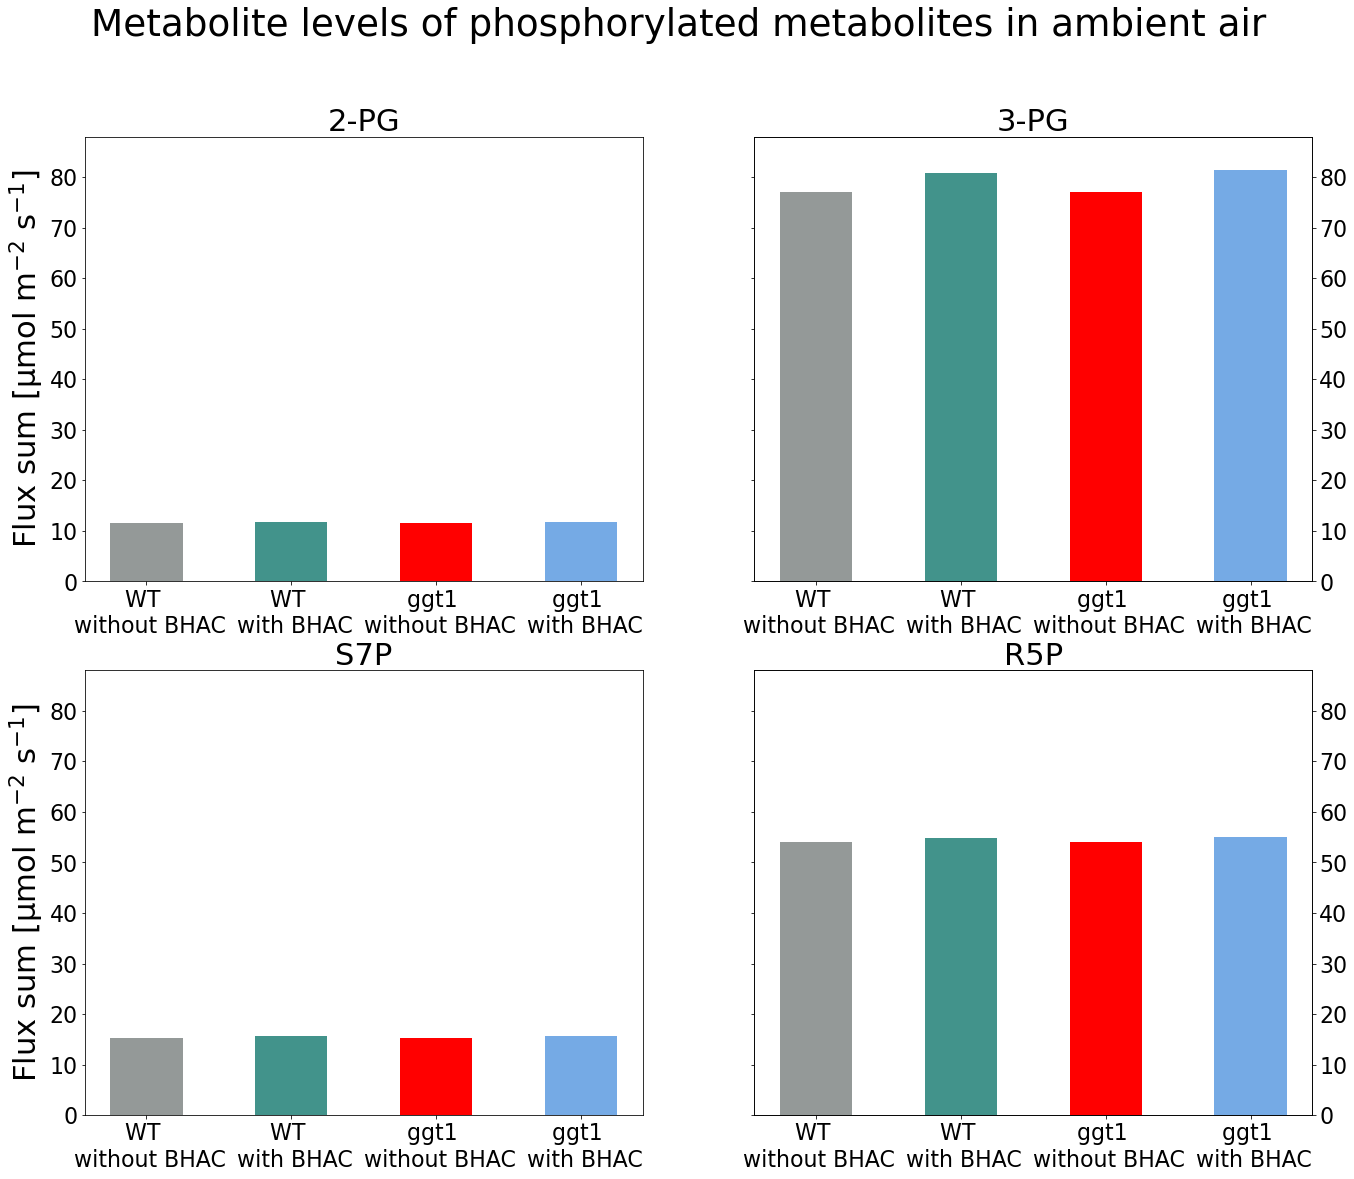

In [202]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(22,18), sharey='all')
#plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=None, hspace=None)
fig.suptitle('Metabolite levels of phosphorylated metabolites in ambient air')

x_titles = ['WT \n without BHAC', 'WT \n with BHAC', 'ggt1 \n without BHAC', 'ggt1 \n with BHAC']

ax1.set(ylabel='Flux sum [\u03BCmol m$^{-2}$ s$^{-1}$]')
ax3.set(ylabel='Flux sum [\u03BCmol m$^{-2}$ s$^{-1}$]')

ax5 = ax4.twinx()
ax5.set_ylim(0,88)
ax6 = ax2.twinx()
ax6.set_ylim(0,88)

ax1.bar(x_titles, pg2_ac, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax1.set_title('2-PG')
ax1.set_ylim(0,88)

ax2.bar(x_titles, pg3_ac, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax2.set_title('3-PG')
ax2.set_ylim(0,88)

ax3.bar(x_titles, s7p_ac, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax3.set_title('S7P')
ax3.set_ylim(0,88)

ax4.bar(x_titles, r5p_ac, width=0.5, color=['#949998', '#42938B', 'r', '#75AAE5'])
ax4.set_title('R5P')
ax4.set_ylim(0,88)

#plt.show()
plt.savefig('figures/fig5b.png', dpi=300)

### Nitrogen Metabolism
Roell et al.:
(0) Ammonia reassimilation and refixation by glutamine synthetase 2/ferredoxin–dependent glutamine:oxoglutarate aminotransferase complex is integral part photorespiration (same as in glutamate assimilation and ammonia reduction)

Roell et al.: in BHAC plants there are metabolic adaptions to compensate for an impaired nitrogen shuttle:
(1.1) use of cytosolic glutamine synthetases
(1.2) avoid chloroplastic nitrogen reassimilation by glutamine synthase (same as with ammonia reduction)
(2) use of glutamate dehydrogenase
(3) excess N stored in urea cycle
(4) ornithine-citrulline shuttle could support mitochondrial chloroplastic nitrogen exchange

#### (0) GS2/Fd-GOGAT complex (in chloroplast)

In [203]:
c3_model.reactions.get_by_id('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p')

Reaction identifier,GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p
Name,GLUTAMATE-SYNTHASE-FERREDOXIN-RXN:Glutamate synthase (ferredoxin)
Memory address,0x01f755464088
Stoichiometry,2_KETOGLUTARATE_p + GLN_p + 2.0 PROTON_p + 2.0 Reduced_ferredoxins_p --> 2.0 GLT_p + 2.0 Oxidized_ferredoxins_p 2-KETOGLUTARATE + GLN + 2.0 PROTON + 2.0 Reduced_ferredoxins[p] --> 2.0 GLT + 2.0 Oxidized_ferredoxins[p]
GPR,
Lower bound,0.0
Upper bound,1000.0


In [204]:
print('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p:')

# pFBA - WT without BHAC
print('WT - BHAC', pFBA_noBHAC.get('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p'))

# pFBA - WT with BHAC
print('WT + BHAC:', pFBA_BHAC.get('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p'))

# pFBA - ggt without BHAC
print('ggt - BHAC:', pFBA_noBHAC_ggt.get('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p'))

# pFBA - ggt with BHAC
print('ggt + BHAC:', pFBA_BHAC_ggt.get('GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p'))

GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p:
WT - BHAC 5.77959
WT + BHAC: 3.24643
ggt - BHAC: 5.77959
ggt + BHAC: 2.93939


In [264]:
c3_model.reactions.get_by_id('GLUTAMINESYN_RXN_p')

Reaction identifier,GLUTAMINESYN_RXN_p
Name,GLUTAMINESYN-RXN:Glutamate--ammonia ligase
Memory address,0x01f7554af488
Stoichiometry,AMMONIUM_p + ATP_p + GLT_p --> ADP_p + GLN_p + 0.9 PROTON_p + Pi_p AMMONIUM + ATP + GLT --> ADP + GLN + 0.9 PROTON + Pi[p]
GPR,
Lower bound,0.0
Upper bound,1000.0


In [266]:
print('GLUTAMINESYN_RXN_p','\n','WT - BHAC', pFBA_noBHAC.get('GLUTAMINESYN_RXN_p'), '\n WT + BHAC', pFBA_BHAC.get('GLUTAMINESYN_RXN_p'), '\n ggt - BHAC', pFBA_noBHAC_ggt.get('GLUTAMINESYN_RXN_p'), '\n ggt + BHAC', pFBA_BHAC_ggt.get('GLUTAMINESYN_RXN_p'))

GLUTAMINESYN_RXN_p 
 WT - BHAC 5.89252 
 WT + BHAC 3.36128 
 ggt - BHAC 5.89252 
 ggt + BHAC 3.05436


Our results are according to Roell et al., because there is a higher flux through the reaction without BHAC (when there is PR)

#### (1) glutamine synthetase
(1.1) Based on the metabolite profiles, we hypothesize three metabolic adaptations that compensate the impaired nitrogen shuttle in BHAC plants. A general response upon impaired GS2/Fd-GOGAT–dependent nitrogen assimilation is the use of cytosolic glutamine synthetases (Roell et al. 2021)
(1.2) Nitrogen conservation by the BHAC is assumed to prevent mitochondrial ammonia release and avoid chloroplastic nitrogen reassimilation by glutamine synthase

In [205]:
# (1.1) cytosolic glutamine synthetase
c3_model.reactions.get_by_id('GLUTAMINESYN_RXN_c')

Reaction identifier,GLUTAMINESYN_RXN_c
Name,GLUTAMINESYN-RXN:Glutamate--ammonia ligase
Memory address,0x01f7554a5848
Stoichiometry,AMMONIUM_c + ATP_c + GLT_c --> ADP_c + GLN_c + 0.55 PROTON_c + Pi_c AMMONIUM + ATP + GLT --> ADP + GLN + 0.55 PROTON + Pi[c]
GPR,
Lower bound,0.0
Upper bound,1000.0


In [206]:
print('GLUTAMINESYN_RXN_c')

# pFBA - WT without BHAC
print('WT - BHAC:', pFBA_noBHAC.get('GLUTAMINESYN_RXN_c'))

# pFBA - WT with BHAC
print('WT + BHAC:', pFBA_BHAC.get('GLUTAMINESYN_RXN_c'))

# pFBA - ggt without BHAC
print('ggt - BHAC:', pFBA_noBHAC_ggt.get('GLUTAMINESYN_RXN_c'))

# pFBA - ggt with BHAC
print('ggt + BHAC:', pFBA_BHAC_ggt.get('GLUTAMINESYN_RXN_c'))

GLUTAMINESYN_RXN_c
WT - BHAC: 0.0
WT + BHAC: 0.0
ggt - BHAC: 0.0
ggt + BHAC: 0.0


The cytosolic glutamine synthase is never used, contradicting Roell et al. results.

In [207]:
# (1.2) avoid chloroplastic glutamine synthase with BHAC

In [208]:
print('GLUTAMINESYN_RXN_p:')

# pFBA - WT without BHAC
print('WT - BHAC:', pFBA_noBHAC.get('GLUTAMINESYN_RXN_p'))

# pFBA - WT with BHAC
print('WT + BHAC:', pFBA_BHAC.get('GLUTAMINESYN_RXN_p'))

# pFBA - ggt without BHAC
print('ggt - BHAC:', pFBA_noBHAC_ggt.get('GLUTAMINESYN_RXN_p'))

# pFBA - ggt with BHAC
print('ggt + BHAC:', pFBA_BHAC_ggt.get('GLUTAMINESYN_RXN_p'))

GLUTAMINESYN_RXN_p:
WT - BHAC: 5.89252
WT + BHAC: 3.36128
ggt - BHAC: 5.89252
ggt + BHAC: 3.05436


There is less flux though the chloroplastic glutamine synthase when BHAC is active, confirming Roell et al. results

#### (2) glutamine dehydrogenase

In [209]:
# glutamate dehydrogenase
c3_model.reactions.get_by_id('GLUTAMATE_DEHYDROGENASE_RXN_m')

Reaction identifier,GLUTAMATE_DEHYDROGENASE_RXN_m
Name,GLUTAMATE-DEHYDROGENASE-RXN:Glutamate dehydrogenase
Memory address,0x01f7554cc1c8
Stoichiometry,GLT_m + NAD_m + WATER_m --> 2_KETOGLUTARATE_m + AMMONIUM_m + NADH_m + PROTON_m GLT + NAD + WATER --> 2-KETOGLUTARATE + AMMONIUM + NADH + PROTON
GPR,
Lower bound,0.0
Upper bound,1000.0


In [210]:
# this reaction just exists in mitochondria
c3_model.reactions.query('GLUTAMATE_DEHYDROGENASE_RXN')

[<Reaction GLUTAMATE_DEHYDROGENASE_RXN_m at 0x1f7554cc1c8>]

In [211]:
print('GLUTAMATE_DEHYDROGENASE_RXN_m:')

# pFBA - WT without BHAC
print('WT - BHAC:', pFBA_noBHAC.get('GLUTAMATE_DEHYDROGENASE_RXN_m'))

# pFBA - WT with BHAC
print('WT + BHAC:', pFBA_BHAC.get('GLUTAMATE_DEHYDROGENASE_RXN_m'))

# pFBA - ggt without BHAC
print('ggt - BHAC:', pFBA_noBHAC_ggt.get('GLUTAMATE_DEHYDROGENASE_RXN_m'))

# pFBA - ggt with BHAC
print('ggt + BHAC:', pFBA_BHAC_ggt.get('GLUTAMATE_DEHYDROGENASE_RXN_m'))

GLUTAMATE_DEHYDROGENASE_RXN_m:
WT - BHAC: 0.0
WT + BHAC: 0.0
ggt - BHAC: 0.0
ggt + BHAC: 0.0


#### (3) urea cycle
excess N stored in urea cycle (reactions according to Metacyc):
- RXN-13202 (6.3.4.16)
- ORNCARBAMTRANSFER-RXN (2.1.3.3)
- ARGSUCCINLYA-RXN (4.3.2.1)
- ARGSUCCINSYN-RXN (6.3.4.5)
- ORNCARBAMTRANSFER-RXN (2.1.3.3)
- ARGINASE-RXN (3.5.3.1)

In [212]:
c3_model.groups.get_by_id('ureacycle').members

[<Reaction RXN_13202_p at 0x1f75522efc8>,
 <Reaction ORNCARBAMTRANSFER_RXN_p at 0x1f75555cb48>,
 <Reaction ARGINASE_RXN_m at 0x1f75524cd48>,
 <Reaction ARGSUCCINLYA_RXN_p at 0x1f75536e108>,
 <Reaction ARGSUCCINSYN_RXN_p at 0x1f7552e8508>]

In [213]:
urea = ['RXN_13202_p', 'ORNCARBAMTRANSFER_RXN_p', 'ARGSUCCINLYA_RXN_p', 'ARGSUCCINSYN_RXN_p', 'ARGINASE_RXN_m', 'ARG_pc', 'GLUTAMATE_N_ACETYLTRANSFERASE_RXN_p']

# ARG_pc added afterwards: produced Arginine is transported into cytosol by ARGSUCCINLYA_RXN_p
# GLUTAMATE_N_ACETYLTRANSFERASE_RXN_p added afterwards: show where the Ornithine for ORNCARBAMTRANSFER_RXN_p is coming from

In [214]:
# pFBA - WT without BHAC
flux_values_sum(urea, 'n', 'wt')

RXN_13202_p = 0.0
ORNCARBAMTRANSFER_RXN_p = 0.07959
ARGSUCCINLYA_RXN_p = 0.07959
ARGSUCCINSYN_RXN_p = 0.07959
ARGINASE_RXN_m = 0.0
GLUTAMATE_N_ACETYLTRANSFERASE_RXN_p = 0.07959

 ---------------- 
 The flux sum is: 0.3184


In [215]:
# pFBA - WT with BHAC
flux_values_sum(urea, 'y', 'wt')

RXN_13202_p = 0.0
ORNCARBAMTRANSFER_RXN_p = 0.08094
ARGSUCCINLYA_RXN_p = 0.08094
ARGSUCCINSYN_RXN_p = 0.08094
ARGINASE_RXN_m = 0.0
GLUTAMATE_N_ACETYLTRANSFERASE_RXN_p = 0.08094

 ---------------- 
 The flux sum is: 0.3238


In [216]:
# pFBA - ggt without BHAC
print('ggt - BHAC:', flux_values_sum(urea, 'n', 'ggt', plot='plot'))

# pFBA - ggt with BHAC
print('ggt + BHAC:', flux_values_sum(urea, 'y', 'ggt', plot='plot'))

ggt - BHAC: 0.3184
ggt + BHAC: 0.3241


The flux sums with an active BHAC in wt and ggt1-1 mutant is slightly higher than without BHAC, confirming Roell et al. results

#### (4) ornithine-citrulline shuttle
ornithine-citrulline shuttle could support mitochondrial-chloroplastic nitrogen exchange

In [217]:
# get all reactions involving Ornithine and Citrulline in all compartments
orn_reactions = search_reactions('L_ORNITHINE', 'all')
cit_reactions = search_reactions('L_CITRULLINE', 'all')

There are 14 reactions including the following metabolites:
 ['L_ORNITHINE_p', 'L_ORNITHINE_m', 'L_ORNITHINE_c'] 

There are 12 reactions including the following metabolites:
 ['L_CITRULLINE_p', 'L_CITRULLINE_m', 'L_CITRULLINE_c'] 



In [218]:
# all reactions that have citrulline and ornithine as metabolites
orn_cit = []
for i in orn_reactions:
    if 'CIT' in c3_model.reactions.get_by_id(i).reaction:
        orn_cit.append(i)
orn_cit

['ORNITHINE_CITRULLINE_pc',
 'ORNCARBAMTRANSFER_RXN_p',
 'ORNITHINE_CITRULLINE_mc']

In [270]:
# pFBA - WT without BHAC
print('flux sums for the all reactions that have both Orn and Cit as metabolites:')
print('WT - BHAC:', pFBA_noBHAC.get('ORNITHINE_CITRULLINE_pc') + pFBA_noBHAC.get('ORNCARBAMTRANSFER_RXN_p') + pFBA_noBHAC.get('ORNITHINE_CITRULLINE_mc'))

# pFBA - WT with BHAC
print('WT + BHAC:', pFBA_BHAC.get('ORNITHINE_CITRULLINE_pc') + pFBA_BHAC.get('ORNCARBAMTRANSFER_RXN_p') + pFBA_BHAC.get('ORNITHINE_CITRULLINE_mc'))

# pFBA - ggt without BHAC
print('ggt - BHAC:', pFBA_noBHAC_ggt.get('ORNITHINE_CITRULLINE_pc') + pFBA_noBHAC_ggt.get('ORNCARBAMTRANSFER_RXN_p') + pFBA_noBHAC_ggt.get('ORNITHINE_CITRULLINE_mc'))

# pFBA - ggt with BHAC
print('ggt + BHAc:', pFBA_BHAC_ggt.get('ORNITHINE_CITRULLINE_pc') + pFBA_BHAC_ggt.get('ORNCARBAMTRANSFER_RXN_p') + pFBA_BHAC_ggt.get('ORNITHINE_CITRULLINE_mc'))

flux sums for the all reactions that have both Orn and Cit as metabolites:
WT - BHAC: 0.07959
WT + BHAC: 0.08094
ggt - BHAC: 0.07959
ggt + BHAc: 0.08103


In [271]:
print('flux sums for all Orn and all Cit reactions:')

# pFBA - WT without BHAC
print('WT - BHAC:',flux_values_sum(orn_reactions, 'n', 'wt', plot='plot') + flux_values_sum(cit_reactions, 'n', 'wt', plot='plot'))

# pFBA - WT with BHAC
print('WT + BHAC:', flux_values_sum(orn_reactions, 'y', 'wt', plot='plot') + flux_values_sum(cit_reactions, 'y', 'wt', plot='plot'))

# pFBA - ggt without BHAC
print('ggt - BHAC:',flux_values_sum(orn_reactions, 'n', 'ggt', plot='plot') + flux_values_sum(cit_reactions, 'n', 'ggt', plot='plot'))

# pFBA - ggt with BHAC
print('ggt + BHAC:',flux_values_sum(orn_reactions, 'y', 'ggt', plot='plot') + flux_values_sum(cit_reactions, 'y', 'ggt', plot='plot'))

flux sums for all Orn and all Cit reactions:
WT - BHAC: 0.3184
WT + BHAC: 0.3238
ggt - BHAC: 0.3184
ggt + BHAC: 0.3242


The flux sums are higher when BHAc is active in ggt1-1 mutant and wt confirming Roell et al. results

## Flux Maps
Flux Maps with Escher could be a great visualisation tool for the future

In [221]:
# visualisation of the BHAC pathway
group = Group('bhac')
group.name = ('β-hydroxyaspartate cycle')
c3_model.add_groups([group])

In [222]:
c3_model.groups.bhac.add_members([
    c3_model.reactions.AGAT_x,c3_model.reactions.BHAA_x, c3_model.reactions.BHAD_x, c3_model.reactions.ISR_x])

In [223]:
c3_model.groups.bhac.members

[<Reaction AGAT_x at 0x1f7556d0608>,
 <Reaction BHAA_x at 0x1f7556d0b88>,
 <Reaction BHAD_x at 0x1f7556d0a88>,
 <Reaction ISR_x at 0x1f7556d0908>]

In [224]:
cm.model_convert(c3_model)

In [225]:
bhac_dict = {}
with c3_model:
    set_bounds('Photon_tx', (0, 1000), c3_model)
    set_bounds('Nitrate_tx', (0, 10), c3_model)
    a = c3_model.optimize().fluxes.to_dict()
    for i in bhac_c3:
        bhac_dict[i] = a.get(i)

bhac_dict

{'AGAT_x': 0.0,
 'BHAA_x': 6.41267851711857,
 'BHAD_x': 6.41267851711857,
 'ISR_x': 6.41267851711857}

In [226]:
bhac_dict = {}
with c3_model:
    set_bounds('Photon_tx', (0, 1000), c3_model)
    set_bounds('Nitrate_tx', (0, 10), c3_model)
    a = flux_variability_analysis(c3_model, bhac_c3, pfba_factor=1)
    for i in bhac_c3:
        bhac_dict[i] = a.get('minimum')[i]
bhac_dict

{'AGAT_x': 10.513568410302751,
 'BHAA_x': 10.51356841033276,
 'BHAD_x': 10.513568410332757,
 'ISR_x': 10.513568410332757}

In [227]:
c3_model.groups.get_by_id('bhac').color_positive = "green"
c3_model.groups.get_by_id('bhac').color_negative = "red"

c3_model.groups.get_by_id('bhac').visualize(
    solution_fluxes=bhac_dict
)

# Pycharm: visualisation is not shown here, type 'jupyter notebook' into terminal to open the code in the browser (local host)

Builder(reaction_data={'AGAT_x': 10.513568410302751, 'BHAA_x': 10.51356841033276, 'BHAD_x': 10.513568410332757…